In [ ]:
#|default_exp mixup

# Original Chris 94.9 on 5ep (not reporduced)

In [51]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from types import SimpleNamespace

In [52]:
# speed mods
from miniai.utils import *

MetricsCB = LazyMetricsCB
ProgressCB = LazyProgressCB

In [3]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=8, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
tds.cached = cache_dataset_as_dict(tds)

In [6]:
def get_model9(act=nn.ReLU, nfs=(32,288,288,288,288,288), norm=nn.BatchNorm2d):#,256
    layers = [ResBlock(1, 32, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [7]:
from torchvision import transforms

In [8]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [9]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

# run

In [ ]:
dls = DataLoaders.from_dd(tds.cached, bs, num_workers=0)

# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics] 
#0.0003 from https://github.com/digantamisra9

In [11]:
def upscale_cb(scale, mode='bilinear'): 
    return BatchTransformCB(lambda b: (F.interpolate(b[0], scale_factor=scale, mode=mode),b[1]),
                            on_val=True, on_train=True)

In [10]:
import timm

In [ ]:
rng = rng_seed

In [ ]:
def run(model, leaky=0.0003, m=1, cbs=tuple(), fit=True, train_cb=TrainCB(), epochs=5, base_lr=2e-2, 
        loss_func=F.cross_entropy, bs=bs, tta=False, dls=None, verbose=False):
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    lr = base_lr*m
    print("Batch size", bs*m)
    dls = dls or DataLoaders.from_dd(tds.cached, bs*m, num_workers=0) 
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    
    cbs = [DeviceCB(), rng_seed, metrics, BatchSchedCB(sched), *cbs, train_cb] 
    learn = Learner(model.apply(iw), dls, loss_func, lr=lr, cbs=cbs, opt_func=optim.AdamW)
    if verbose: 
        print(torch.randn([3]))
        print(next(iter(learn.dls.train))[1])
    if fit:
        learn.fit(epochs, cbs=[TimeItCB(), ProgressCB(plot=True)])
    if tta:
        ## TTA
        ap1, at = learn.capture_preds()
        ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
        ap2, at = learn.capture_preds(cbs=[ttacb])
        ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
        if verbose: print('TTA:', round((ap==at).float().mean().item(), 4))
    
    return learn

# MixUp persample idxbased

In [ ]:
xb,yb = fc.first(dls.train)

In [ ]:
xb.shape

torch.Size([256, 1, 28, 28])

In [ ]:
transforms.Pad(2,padding_mode="edge")(xb).shape


torch.Size([256, 1, 32, 32])

In [ ]:
@inplace
def transformi32(b): b[xl] = [TF.pad((TF.to_tensor(xb)-xmean)/xstd , 2,padding_mode="edge") for o in b[xl]]

dsd32 = load_dataset(name)
tds32 = dsd.with_transform(transformi)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds32.cached = cache_dataset_as_dict(tds32)

In [ ]:
dls32 = DataLoaders.from_dd(tds32.cached, bs, num_workers=0)

In [ ]:
def mixup_data_float(b2, b1=None, sampler=torch.distributions.Beta(tensor(0.5), tensor(0.5)).sample, classes=10, permute_1=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    r = SimpleNamespace()    
    if b1 is None: b1=b2 # first batch uses it self
    x1,y1 = b1
    x2,y2 = b2
    
    if x1.shape[0] != x2.shape[0]: x1,y1=x2,y2 # last batch uses it self

    batch_size = x2.shape[0]
    r.lam = sampler([batch_size]).to(x2.device)
    
    # permute prev batch
    if permute_1:
        r.index = torch.randperm(batch_size).to(x2.device)
        x1,y1 = x1[r.index], y1[r.index]
    
    #r.mixed_x = r.lam.reshape(-1,*[1]*(len(x2.shape)-1)) * x2 + (1 - r.lam.reshape(-1,*[1]*(len(x2.shape)-1))) * x1
    r.mixed_x = torch.lerp(x2, x1, r.lam.reshape(-1,*[1]*(len(x2.shape)-1)))
    
    r.y1 = F.one_hot(y1, num_classes=classes).float()
    r.y2 = F.one_hot(y2, num_classes=classes).float()
    #r.mixed_y = r.y2 + r.lam.reshape(-1,1)*(r.y1-r.y2)
    r.mixed_y = torch.lerp(r.y2, r.y1, r.lam.reshape(-1,*[1]*(len(r.y2.shape)-1)))
    return r


tensor([0.73126239, 0.79491055, 0.25722787, 0.99731880, 0.37557158, 0.95657641], device='cuda:0')

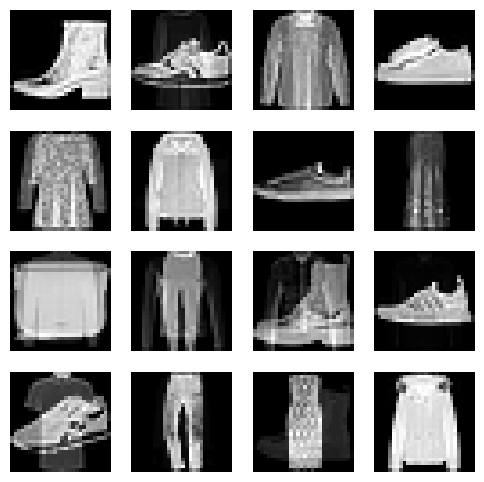

In [ ]:
rng.set_seed(1)
xb,yb = (xb.to(def_device),yb.to(def_device))
r = mixup_data_float((xb,yb))
show_images(r.mixed_x[:16], imsize=1.5)
r.lam[:6]

In [18]:
#| export
def mce_float(preds, r, eta=None, **kw): return F.cross_entropy(preds, r.mixed_y,**kw)

In [ ]:
rng.previous()
preds = torch.no_grad()(get_model().to(def_device))(r.mixed_x)
mce_float(preds, r)

tensor(2.30265188, device='cuda:0')

In [17]:
#| export
def mixup_data_int(b2, b1=None, sampler=torch.distributions.Beta(tensor(0.5), tensor(0.5)).sample, classes=10, permute_1=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    r = SimpleNamespace()    
    if b1 is None: b1=b2 # first batch uses it self
    x1,y1 = b1
    x2,y2 = b2
    
    if x1.shape[0] != x2.shape[0]: x1,y1=x2,y2 # last batch uses it self

    batch_size = x2.shape[0]
    r.lam = sampler([batch_size]).to(x2.device)
    
    # permute prev batch
    if permute_1:
        r.index = torch.randperm(batch_size).to(x2.device)
        x1,y1 = x1[r.index], y1[r.index]
    # x2 + lam*(x1-x2)
    r.mixed_x = torch.lerp(x2, x1, r.lam.reshape(-1,*[1]*(len(x2.shape)-1)))
    r.y1 = y1
    r.y2 = y2
    r.y = torch.cat([y2[:,None],y1[:,None]],dim=1)
    r.top1y=torch.gather(r.y, 1, (r.lam.expand(r.y1.shape) > 0.5).long()[:,None]).squeeze(-1)
    return r


In [ ]:
rng.previous()
r2 = mixup_data_int((xb,yb))
(r.mixed_x == r2.mixed_x).all(), r.lam[:6]

(tensor(True, device='cuda:0'),
 tensor([0.73126239, 0.79491055, 0.25722787, 0.99731880, 0.37557158, 0.95657641], device='cuda:0'))

In [ ]:
r2.top1y[:5], r2.y[:5], r2.lam[:5], 

(tensor([9, 7, 6, 7, 2], device='cuda:0'),
 tensor([[9, 9],
         [3, 7],
         [6, 1],
         [8, 7],
         [2, 6]], device='cuda:0'),
 tensor([0.73126239, 0.79491055, 0.25722787, 0.99731880, 0.37557158], device='cuda:0'))

In [66]:
#| export 
def mce_int(preds, r, reduction=True, eta=None, **kw):
    ce = torch.lerp(F.cross_entropy(preds, r.y2, reduction='none', **kw), 
                    F.cross_entropy(preds, r.y1, reduction='none', **kw), r.lam)
    return ce.mean(-1) if reduction else ce

In [ ]:
mce_int(preds,r2).item(),mce_int(preds,r2, label_smoothing=0.1).item(),mce_int(preds,r2, label_smoothing=0.5).item(),

(2.3026516437530518, 2.3026888370513916, 2.30283784866333)

In [13]:
#| export
def mixup_data_per_batch(b,b2=None, sampler=torch.distributions.Beta(tensor(1), tensor(1)).sample):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    x,y=b
    r = SimpleNamespace()   
    r.lam = sampler([1]).to(x.device)
    batch_size = x.shape[0]
    r.index = torch.randperm(batch_size).to(x.device)
    # this is less stable than lerp
    #r.mixed_x = x + r.lam * (x[r.index, :] - x)
    r.mixed_x=torch.lerp(x, x[r.index, :], r.lam)
    r.y2, r.y1 = y, y[r.index]
    return r

def mixup_criterion_per_batch(pred, r, lf=F.cross_entropy, eta=None, **kw):
    return torch.lerp(lf(pred, r.y2, **kw), lf(pred, r.y1, **kw), r.lam).squeeze()

In [ ]:
rng.previous()
r = mixup_data_int((xb,yb), sampler=lambda x:torch.tensor([0.2]))
#r = mixup_data_int((xb.double(),yb.double()), sampler=lambda x:torch.tensor([0.2]).double())
r.mixed_x=r.mixed_x.float()
preds = torch.no_grad()(get_model().to(def_device))(r.mixed_x)

In [ ]:
r.lam, r.top1y.shape

(tensor([0.20000000], device='cuda:0'), torch.Size([256]))

In [ ]:
mce_int(preds,r)

tensor(2.30120850, device='cuda:0')

In [ ]:
r.lam = r.lam.min()
mixup_criterion_per_batch(preds, r)

tensor(2.30120802, device='cuda:0')

In [ ]:
rng.previous()
r2 = mixup_data_per_batch((xb,yb), sampler=lambda x: torch.tensor([0.2]))
#r2 = mixup_data_per_batch((xb.double(),yb.double()), sampler=lambda x: torch.tensor([0.2]).double())
r2.mixed_x=r2.mixed_x.float()
#mixup_criterion_per_batch(preds,r2)

In [ ]:
(r2.mixed_x - r.mixed_x).abs().sum()

tensor(0., device='cuda:0')

In [ ]:
(r2.mixed_x - r.mixed_x).abs().sum()

tensor(0., device='cuda:0')

In [ ]:
F.cross_entropy(preds, r.y1, reduction='none').mean(-1).item()

2.3013412952423096

In [ ]:
F.cross_entropy(preds, r.y1, reduction='none', label_smoothing=0.1).mean(-1).item()

2.3015024662017822

In [ ]:
F.cross_entropy(preds, r.y1, reduction='mean', label_smoothing=0.1).item()

2.3015024662017822

In [ ]:
l1=F.cross_entropy(preds, r.y1, reduction='mean')
l1

tensor(2.30134153, device='cuda:0')

In [ ]:
l2=F.cross_entropy(preds, r.y2)
l2

tensor(2.30117464, device='cuda:0')

In [ ]:
l2 * r.lam + (1-r.lam)*l1

tensor(2.30130816, device='cuda:0')

In [ ]:
l2.double() * r.lam.double() + (1-r.lam.double())*l1.double()

tensor(2.30130816, device='cuda:0', dtype=torch.float64)

In [ ]:
l1.double()  + (r.lam.double())*(l2.double()-l1.double())

tensor(2.30130816, device='cuda:0', dtype=torch.float64)

In [ ]:
l1  + (r.lam)*(l2-l1)

tensor(2.30130816, device='cuda:0')

In [ ]:
torch.lerp(l1,l2,r.lam)

tensor(2.30130816, device='cuda:0')

In [ ]:
torch.lerp(l2,l1,r.lam)

tensor(2.30120802, device='cuda:0')

In [ ]:
torch.lerp(l2.double(),l1.double(),r.lam.double())

tensor(2.30120802, device='cuda:0', dtype=torch.float64)

In [ ]:
torch.lerp??

Docstring:
lerp(input, end, weight, *, out=None)

Does a linear interpolation of two tensors :attr:`start` (given by :attr:`input`) and :attr:`end` based
on a scalar or tensor :attr:`weight` and returns the resulting :attr:`out` tensor.

.. math::
    \text{out}_i = \text{start}_i + \text{weight}_i \times (\text{end}_i - \text{start}_i)

The shapes of :attr:`start` and :attr:`end` must be
:ref:`broadcastable <broadcasting-semantics>`. If :attr:`weight` is a tensor, then
the shapes of :attr:`weight`, :attr:`start`, and :attr:`end` must be :ref:`broadcastable <broadcasting-semantics>`.

Args:
    input (Tensor): the tensor with the starting points
    end (Tensor): the tensor with the ending points
    weight (float or tensor): the weight for the interpolation formula

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> start = torch.arange(1., 5.)
    >>> end = torch.empty(4).fill_(10)
    >>> start
    tensor([ 1.,  2.,  3.,  4.])
    >>> end
    tensor([ 1

In [ ]:
r2.lam.shape

torch.Size([1])

In [14]:
class MixUpCBOld(TrainCB):
    def __init__(self,alpha=0.4, mix_data=mixup_data_per_batch, mix_loss=mixup_criterion_per_batch, label_smoothing=0.0,**kw): 
        super().__init__(**kw)
        self.alpha = alpha
        self.dist = torch.distributions.Beta(self.alpha,self.alpha)
        self.mix_data = mix_data
        self.loss_func = mix_loss
        self.label_smoothing = label_smoothing
        
    def before_fit(self, learn):
        self.base_lf = learn.loss_func
        
    def sample(self, shape): return self.dist.sample([1])
    
    def before_batch(self, learn):
        if learn.training and self.alpha is not None: 
            r = mixup_data_per_batch(learn.batch, sampler=self.sample)
            learn.batch = r.mixed_x, learn.batch[1]
            learn.mixup = r

    def get_loss(self, learn):
        if learn.training and self.alpha is not None:
            learn.loss = self.loss_func(learn.preds, learn.mixup, label_smoothing=self.label_smoothing) # todo  *learn.batch[self.n_inp:]   
        else:
            super().get_loss(learn)

## MixUpCB

In [15]:
#| export
class MixUpCB(TrainCB):
    def __init__(self,alpha=0.4, use_prev=False, eta=0.1, per_batch=False, loss_func=mce_int, label_smoothing=0.0, **kw): 
        super().__init__(**kw)
        self.alpha = alpha or 0.0
        self.dist = torch.distributions.Beta(self.alpha, self.alpha)
        self.prev = None
        self.use_prev = use_prev
        self.eta = eta 
        self.per_batch = per_batch
        self.loss_func = loss_func
        self.label_smoothing = label_smoothing
    def before_epoch(self, learn):
        self.prev = None
            
    def sample(self, shape): 
        if self.per_batch: return self.dist.sample([1])
        return self.dist.sample(shape)
    
    def before_batch(self, learn):
        if learn.training and self.alpha: 
            r = mixup_data_int(learn.batch, self.prev, sampler=self.sample)
            if self.use_prev: self.prev = learn.batch
            learn.mixup = r
            learn.batch = r.mixed_x, getattr(r,'top1y', learn.batch[1])
            
    def get_loss(self, learn):
        if learn.training and self.alpha:
            #import pdb;pdb.set_trace()
            learn.loss = self.loss_func(learn.preds, learn.mixup, eta=self.eta, label_smoothing=self.label_smoothing)
        else:
            super().get_loss(learn)

NameError: name 'mce_int' is not defined

In [ ]:
MixUp4CB=MixUpCB

### Compare two Implementations

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [ ]:
class CmpOneBatchCB(Callback):
    order=1000
    def __init__(self, batches=1):self.batches=batches
    def after_batch(self, learn):
        learn.batches = getattr(learn, 'batches', self.batches)
        print("x mean:",learn.batch[0].float().mean().item(), "y mean:",learn.batch[1].float().mean().item(),)
        print("loss:",learn.loss.item(), "iter", learn.iter)
        if learn.iter+1 == self.batches:
            raise CancelFitException()
    

In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[CmpOneBatchCB(2)], 
    train_cb=MixUpCB(0.4, use_prev=False, eta=None, per_batch=True, label_smoothing=.0), fit=False)
learn1.fit(1)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
Using seed 1
x mean: -0.01650918833911419 y mean: 4.3359375
loss: 2.665759325027466 iter 0
x mean: -0.017509086057543755 y mean: 4.82421875
loss: 1.7376928329467773 iter 1
lam tensor([0.22733529], device='cuda:0')
2.3712218535365537e-05
tensor([-0.39390171,  0.60668641,  1.53214383,  0.02244921,  0.55897146,  0.73408067,  0.97765958,  1.12622154,  0.45906696, -0.41157907])


In [ ]:
rng.set_seed(1)
learn2 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[CmpOneBatchCB(2)], 
    train_cb=MixUpCBOld(0.4),# mix_data=mixup_data_prev), 
    fit=True)
print('lam', learn2.mixup.lam)
print(learn2.model(xb.to('cuda')).mean().item())
A=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
Using seed 1


x mean: -0.01650918833911419 y mean: 4.3359375
loss: 2.665759325027466 iter 0
x mean: -0.017509086057543755 y mean: 4.82421875
loss: 1.737692952156067 iter 1
lam tensor([0.22733529], device='cuda:0')
2.3712218535365537e-05
tensor([-0.39390171,  0.60668641,  1.53214383,  0.02244921,  0.55897146,  0.73408067,  0.97765958,  1.12622154,  0.45906696, -0.41157907])


In [ ]:
r1,r2=learn1.mixup,learn2.mixup

In [ ]:
(r1.mixed_x==r2.mixed_x).all()

tensor(True, device='cuda:0')

In [ ]:
(learn1.preds == learn2.preds).all()

tensor(True, device='cuda:0')

In [ ]:
mce_int??

Signature: mce_int(preds, r, eta=None, **kw)
Docstring: <no docstring>
Source:   
def mce_int(preds, r, eta=None, **kw):
    ce = torch.lerp(F.cross_entropy(preds, r.y2, reduction='none', **kw), 
                    F.cross_entropy(preds, r.y1, reduction='none', **kw), r.lam)
    return ce.mean(-1)
File:      /tmp/ipykernel_32469/2661331135.py
Type:      function

In [ ]:
preds = learn1.preds


In [ ]:
mce_int(preds,r1), mixup_criterion_per_batch(preds,r1)

(tensor(1.73769283, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(1.73769295, device='cuda:0', grad_fn=<SqueezeBackward0>))

In [ ]:
torch.randn(10).sort()

torch.return_types.sort(
values=tensor([-1.47450209, -1.46573043, -0.98106223, -0.67551804, -0.28868505,  0.31581515,  0.50688583,  0.69000548,  0.82261223,  1.26742983]),
indices=tensor([7, 4, 9, 0, 1, 3, 8, 2, 6, 5]))

In [ ]:
(
 F.cross_entropy(preds.float().cpu(), r1.y2.cpu()),
 F.cross_entropy(preds.double(), r1.y2),
 F.cross_entropy(preds.float().to('cuda'), r1.y2.to('cuda')),
 F.cross_entropy(preds, r1.y2,reduction='none').mean(-1),
 F.cross_entropy(preds, r1.y2,reduction='none').double().mean(-1),
 F.cross_entropy(preds, r1.y2,reduction='none').sort().values.mean(-1),
 F.cross_entropy(preds, r1.y2,reduction='none').sum()/r1.y2.shape[0])

(tensor(1.52507210, grad_fn=<NllLossBackward0>),
 tensor(1.52507217, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward0>),
 tensor(1.52507222, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.52507210, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(1.52507218, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>),
 tensor(1.52507210, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(1.52507210, device='cuda:0', grad_fn=<DivBackward0>))

### Speed test of 5 epoch 32 vs 28

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.866,0.546,0,train
0.884,0.378,0,eval
0.909,0.288,1,train
0.907,0.284,1,eval
0.930,0.209,2,train
0.925,0.211,2,eval
0.952,0.144,3,train
0.937,0.188,3,eval
0.975,0.082,4,train
0.941,0.185,4,eval


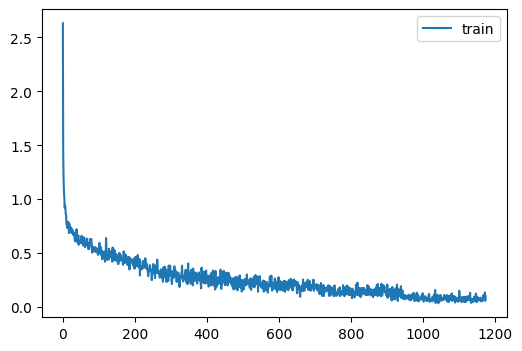

Fit 5 in: 126.24s, setup: 0.00s, 23.06 ± 0.11s per epoch, 0.01 ± 0.01s per batch


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=5, 
    cbs=[], fit=True)


Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.866,0.546,0,train
0.884,0.378,0,eval
0.909,0.288,1,train
0.907,0.284,1,eval
0.930,0.209,2,train
0.925,0.211,2,eval
0.952,0.144,3,train
0.937,0.188,3,eval
0.975,0.082,4,train
0.941,0.185,4,eval


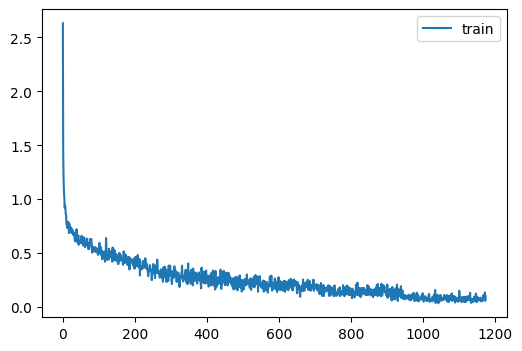

Fit 5 in: 121.35s, setup: 0.00s, 23.23 ± 0.03s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=5, 
    cbs=[], fit=True, dls=dls32)

### Compare 5 epoch

In [ ]:
def mce_int_prec(preds, r, eta=None, **kw):
    red='none'
    ce = torch.lerp(F.cross_entropy(preds, r.y2, reduction=red, **kw), 
                    F.cross_entropy(preds, r.y1, reduction=red, **kw), r.lam)
    return ce.double().mean(-1)

In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[], 
    train_cb=MixUpCB(0.4, use_prev=False, eta=None, per_batch=True, label_smoothing=0.1), fit=True)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.873,0.451,0,train
0.913,0.280,0,eval


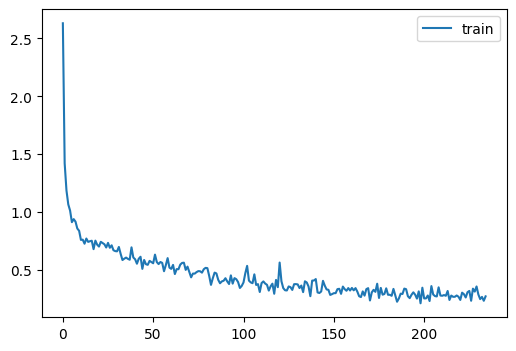

Fit 1 in: 24.69s, setup: 0.00s, 22.79 ± 0.00s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[], 
    #train_cb=MixUpCB(0.4, use_prev=False, eta=None, per_batch=True, loss_func=mce_int_prec, label_smoothing=0.1), 
    fit=True)

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.488,0.813,0,train
0.907,0.329,0,eval


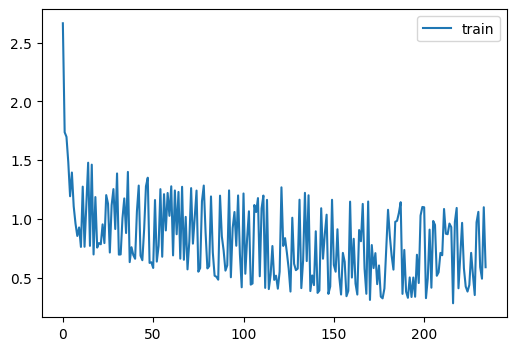

Fit 1 in: 24.86s, setup: 0.00s, 22.92 ± 0.00s per epoch, 0.01 ± 0.00s per batch
lam tensor([0.09516283], device='cuda:0')
-0.02931678667664528
tensor([-1.19561470, -0.22153053, -1.68820953, -0.08950519,  1.88223028,  1.15275347, -2.57176828, -0.68397009, -0.75691664,  0.34121916])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[], 
    train_cb=MixUpCB(0.4, use_prev=False, eta=None, per_batch=True, loss_func=mce_int_prec, label_smoothing=0.0), fit=True)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.488,0.813,0,train
0.907,0.329,0,eval


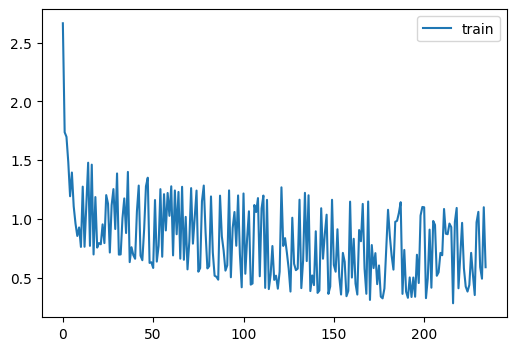

Fit 1 in: 24.79s, setup: 0.00s, 22.84 ± 0.00s per epoch, 0.01 ± 0.00s per batch
lam tensor([0.09516283], device='cuda:0')
-0.02931678667664528
tensor([-1.19561470, -0.22153053, -1.68820953, -0.08950519,  1.88223028,  1.15275347, -2.57176828, -0.68397009, -0.75691664,  0.34121916])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[], 
    train_cb=MixUpCBOld(0.4, label_smoothing=0.0), fit=True)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item()),
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.485,0.855,0,train
0.908,0.316,0,eval


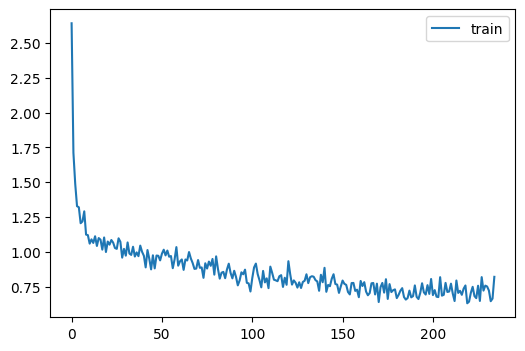

Fit 1 in: 24.75s, setup: 0.00s, 22.84 ± 0.00s per epoch, 0.01 ± 0.00s per batch
-0.014732873998582363
tensor([ 0.78424639, -1.35956526, -0.37369564, -1.91380894, -0.07987453,  1.13563585, -0.60096484,  0.34026110,  2.84133482,  0.54656488])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[], 
    train_cb=MixUpCB(0.4, use_prev=False, eta=None, per_batch=False, loss_func=mce_int_prec, label_smoothing=0.1), fit=True)
print(learn1.model(xb.to('cuda')).mean().item()),
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
Using seed tensor(1791095845)


accuracy,loss,epoch,train
0.874,0.452,0,train
0.913,0.278,0,eval


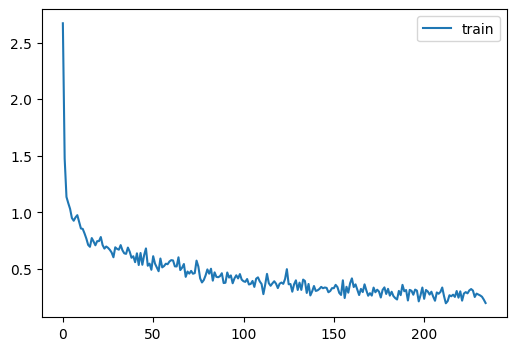

Fit 1 in: 25.22s, setup: 0.00s, 23.28 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4282876139)


accuracy,loss,epoch,train
0.873,0.452,0,train
0.909,0.287,0,eval


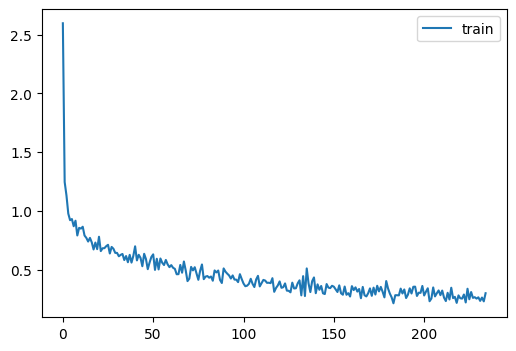

Fit 1 in: 25.21s, setup: 0.00s, 23.28 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(3093770124)


accuracy,loss,epoch,train
0.872,0.460,0,train
0.912,0.285,0,eval


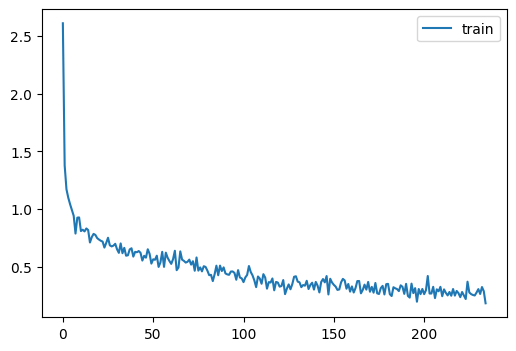

Fit 1 in: 25.22s, setup: 0.00s, 23.29 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4005303368)


accuracy,loss,epoch,train
0.874,0.452,0,train
0.910,0.281,0,eval


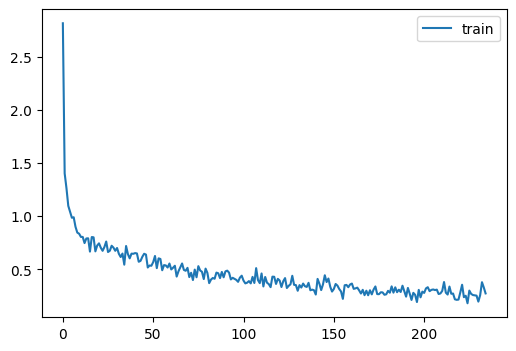

Fit 1 in: 25.20s, setup: 0.00s, 23.27 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(491263)


accuracy,loss,epoch,train
0.872,0.456,0,train
0.911,0.281,0,eval


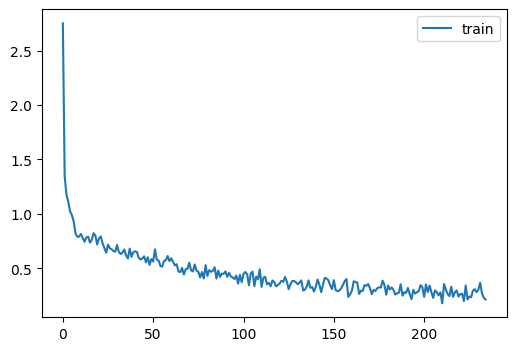

Fit 1 in: 25.19s, setup: 0.00s, 23.26 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(550290313)


accuracy,loss,epoch,train
0.872,0.454,0,train
0.911,0.279,0,eval


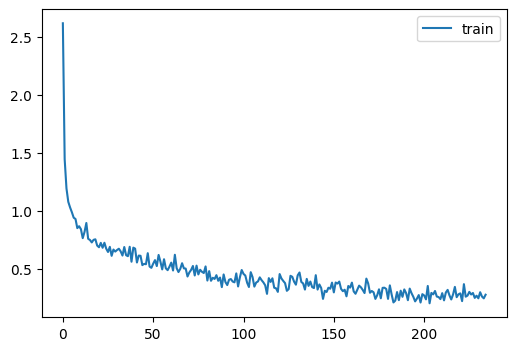

Fit 1 in: 25.22s, setup: 0.00s, 23.30 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(1298508491)


accuracy,loss,epoch,train
0.869,0.462,0,train
0.912,0.280,0,eval


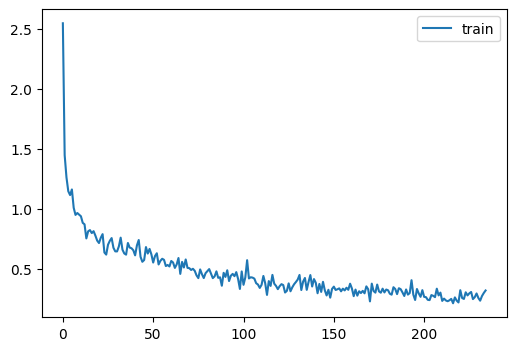

Fit 1 in: 25.19s, setup: 0.00s, 23.27 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4290846341)


accuracy,loss,epoch,train
0.873,0.449,0,train
0.912,0.276,0,eval


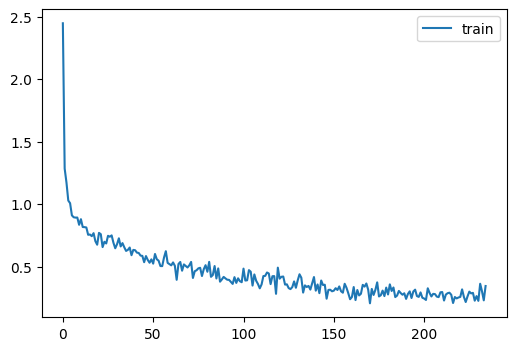

Fit 1 in: 25.22s, setup: 0.00s, 23.30 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(630311759)


accuracy,loss,epoch,train
0.873,0.456,0,train
0.913,0.275,0,eval


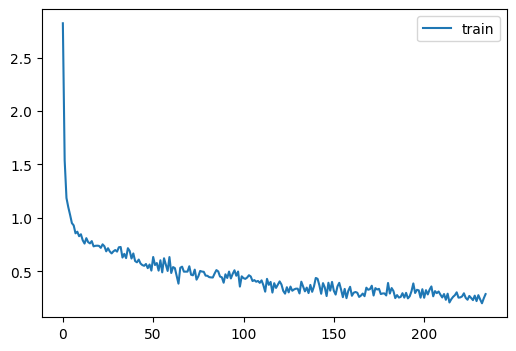

Fit 1 in: 25.20s, setup: 0.00s, 23.28 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(1013994432)


accuracy,loss,epoch,train
0.876,0.450,0,train
0.914,0.278,0,eval


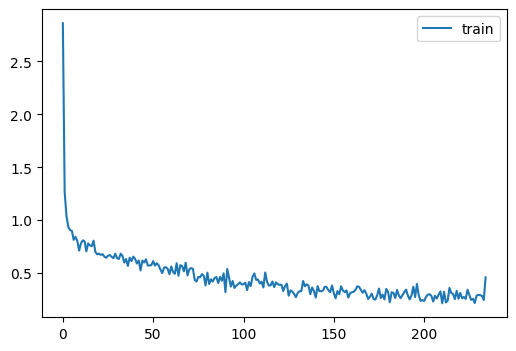

Fit 1 in: 25.22s, setup: 0.00s, 23.29 ± 0.00s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
results5 =[] 
for s in torch.randint(2**32 - 1,(10,)):
    rng.set_seed(s)
    learn1 = run(
        get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
        base_lr=1e-2, epochs=1, 
        cbs=[], 
        #train_cb=MixUpCBOld(0.4, label_smoothing=0.0),
        fit=True)
    results5.append(metrics.metrics['accuracy'].compute().item())
    

Batch size 256
Using seed tensor(1791095845)


accuracy,loss,epoch,train
0.440,0.846,0,train
0.904,0.328,0,eval


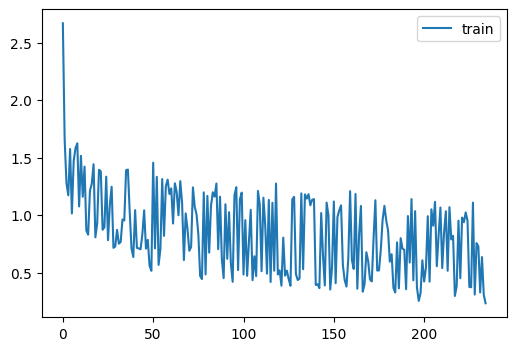

Fit 1 in: 25.34s, setup: 0.00s, 23.41 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4282876139)


accuracy,loss,epoch,train
0.469,0.856,0,train
0.903,0.348,0,eval


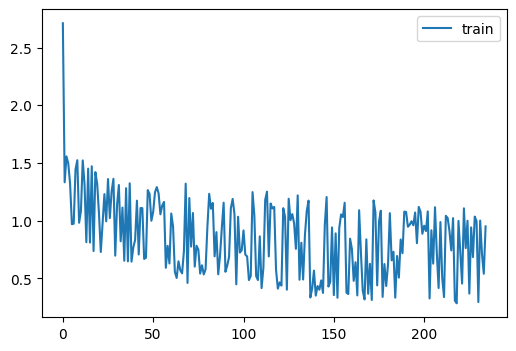

Fit 1 in: 25.15s, setup: 0.00s, 23.22 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(3093770124)


accuracy,loss,epoch,train
0.492,0.848,0,train
0.905,0.334,0,eval


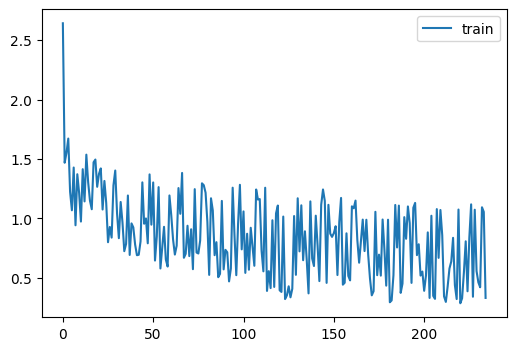

Fit 1 in: 25.31s, setup: 0.00s, 23.38 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4005303368)


accuracy,loss,epoch,train
0.508,0.813,0,train
0.905,0.332,0,eval


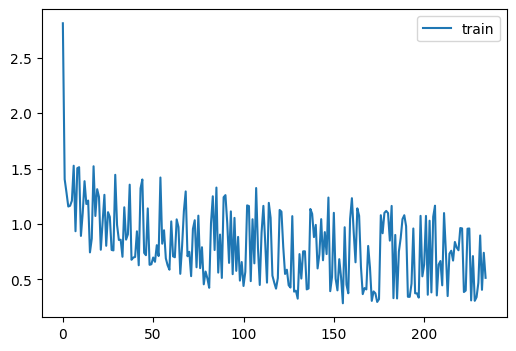

Fit 1 in: 25.27s, setup: 0.00s, 23.32 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(491263)


accuracy,loss,epoch,train
0.472,0.858,0,train
0.908,0.344,0,eval


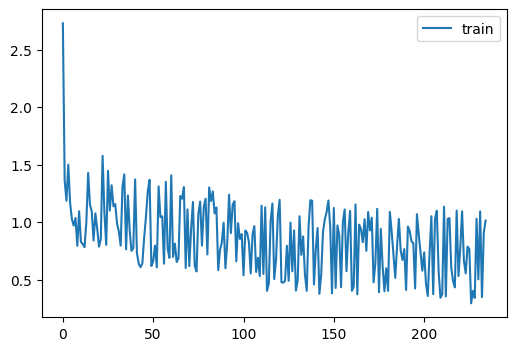

Fit 1 in: 25.28s, setup: 0.00s, 23.35 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(550290313)


accuracy,loss,epoch,train
0.541,0.835,0,train
0.906,0.334,0,eval


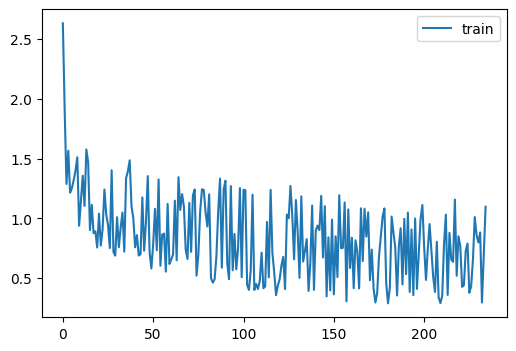

Fit 1 in: 25.27s, setup: 0.00s, 23.35 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(1298508491)


accuracy,loss,epoch,train
0.466,0.838,0,train
0.907,0.332,0,eval


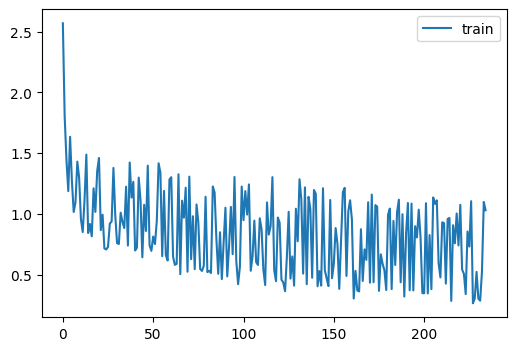

Fit 1 in: 25.28s, setup: 0.00s, 23.35 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4290846341)


accuracy,loss,epoch,train
0.505,0.825,0,train
0.908,0.323,0,eval


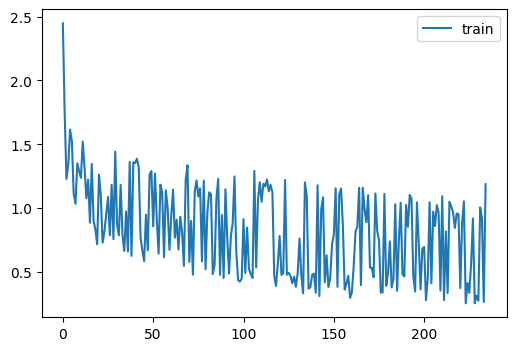

Fit 1 in: 25.33s, setup: 0.00s, 23.41 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(630311759)


accuracy,loss,epoch,train
0.516,0.844,0,train
0.909,0.329,0,eval


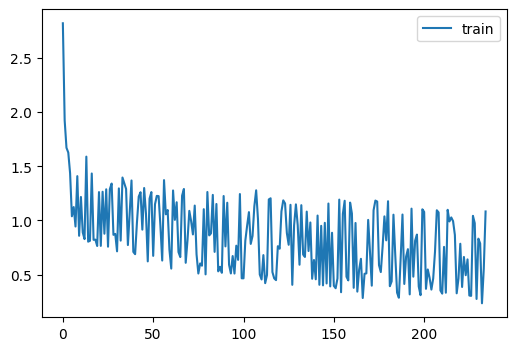

Fit 1 in: 25.57s, setup: 0.00s, 23.61 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(1013994432)


accuracy,loss,epoch,train
0.509,0.859,0,train
0.909,0.329,0,eval


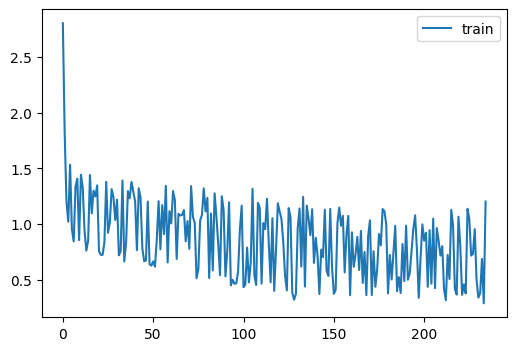

Fit 1 in: 25.33s, setup: 0.00s, 23.34 ± 0.00s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
results4 =[] 
for s in torch.randint(2**32 - 1,(10,)):
    rng.set_seed(s)
    learn1 = run(
        get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
        base_lr=1e-2, epochs=1, 
        cbs=[], 
        train_cb=MixUpCBOld(0.4, label_smoothing=0.0), fit=True)
    results4.append(metrics.metrics['accuracy'].compute().item())
    

Batch size 256
Using seed tensor(1791095845)


accuracy,loss,epoch,train
0.440,0.846,0,train
0.904,0.328,0,eval


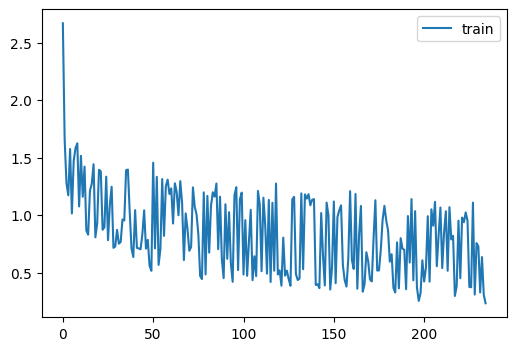

Fit 1 in: 25.26s, setup: 0.00s, 23.03 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4282876139)


accuracy,loss,epoch,train
0.469,0.856,0,train
0.903,0.348,0,eval


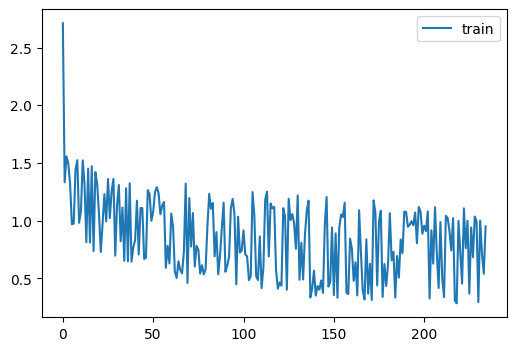

Fit 1 in: 25.01s, setup: 0.00s, 23.07 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(3093770124)


accuracy,loss,epoch,train
0.492,0.848,0,train
0.905,0.334,0,eval


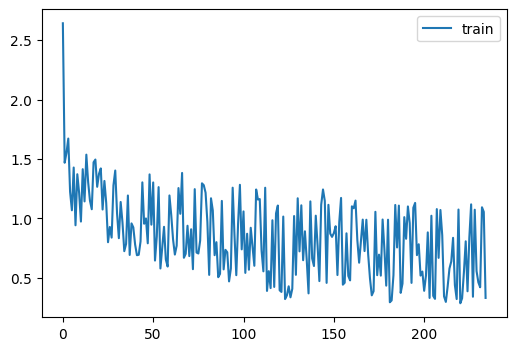

Fit 1 in: 25.11s, setup: 0.00s, 23.17 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4005303368)


accuracy,loss,epoch,train
0.508,0.813,0,train
0.905,0.332,0,eval


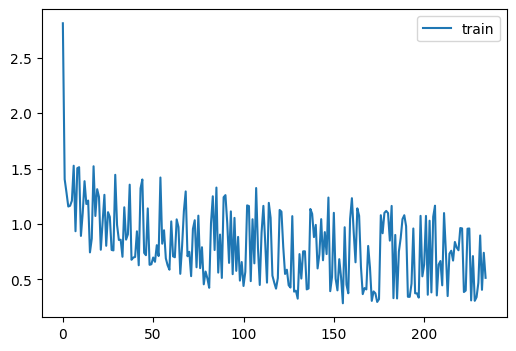

Fit 1 in: 25.17s, setup: 0.00s, 23.23 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(491263)


accuracy,loss,epoch,train
0.472,0.858,0,train
0.908,0.344,0,eval


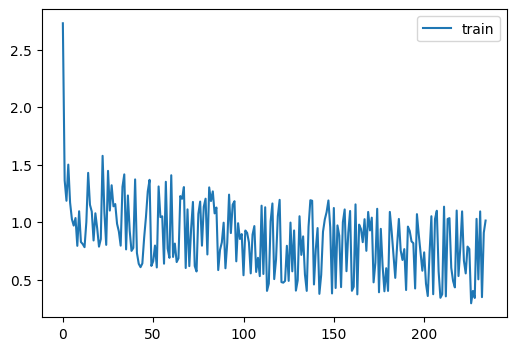

Fit 1 in: 25.23s, setup: 0.00s, 23.30 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(550290313)


accuracy,loss,epoch,train
0.541,0.835,0,train
0.906,0.334,0,eval


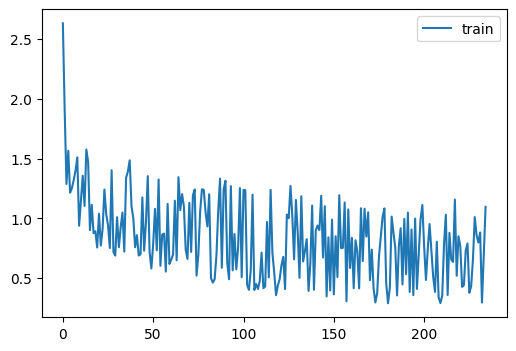

Fit 1 in: 25.21s, setup: 0.00s, 23.27 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(1298508491)


accuracy,loss,epoch,train
0.466,0.838,0,train
0.907,0.332,0,eval


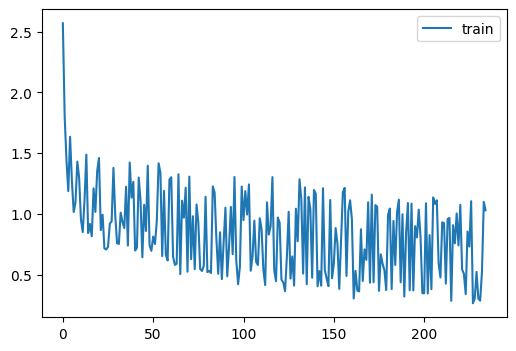

Fit 1 in: 25.20s, setup: 0.00s, 23.28 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4290846341)


accuracy,loss,epoch,train
0.505,0.825,0,train
0.908,0.323,0,eval


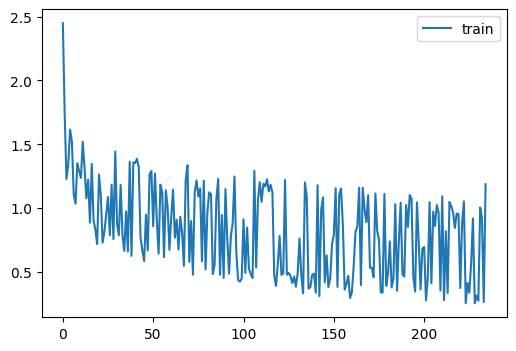

Fit 1 in: 25.23s, setup: 0.00s, 23.31 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(630311759)


accuracy,loss,epoch,train
0.516,0.844,0,train
0.909,0.329,0,eval


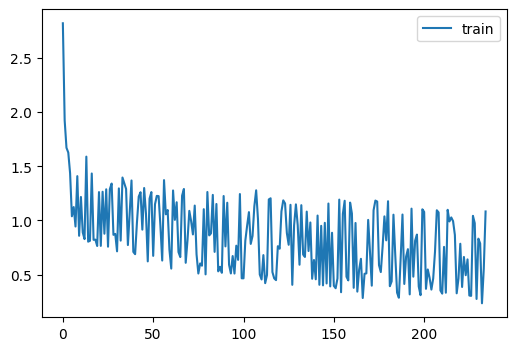

Fit 1 in: 25.26s, setup: 0.00s, 23.34 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(1013994432)


accuracy,loss,epoch,train
0.509,0.859,0,train
0.909,0.329,0,eval


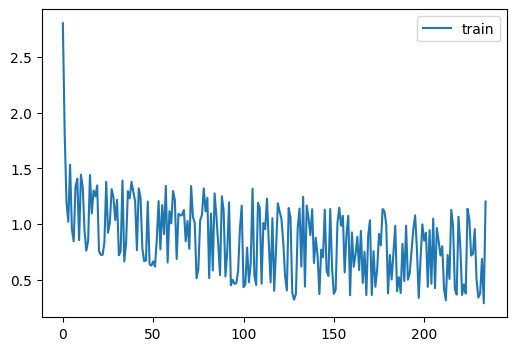

Fit 1 in: 25.28s, setup: 0.00s, 23.35 ± 0.00s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
results3 =[] 
for s in torch.randint(2**32 - 1,(10,)):
    rng.set_seed(s)
    learn1 = run(
        get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
        base_lr=1e-2, epochs=1, 
        cbs=[], 
        train_cb=MixUpCB(0.4, use_prev=False, eta=None, per_batch=True, loss_func=mce_int, label_smoothing=0.0), fit=True)
    results3.append(metrics.metrics['accuracy'].compute().item())
    

Batch size 256
Using seed tensor(1791095845)


accuracy,loss,epoch,train
0.802,1.132,0,train
0.902,0.380,0,eval


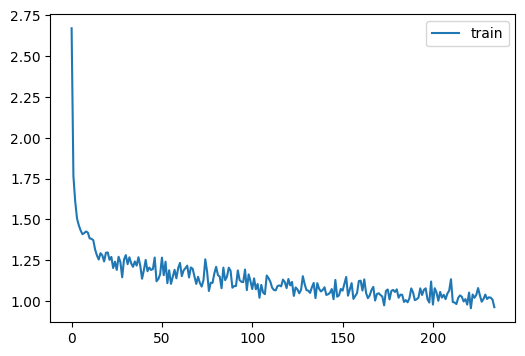

Fit 1 in: 25.23s, setup: 0.00s, 23.30 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4282876139)


accuracy,loss,epoch,train
0.799,1.137,0,train
0.904,0.385,0,eval


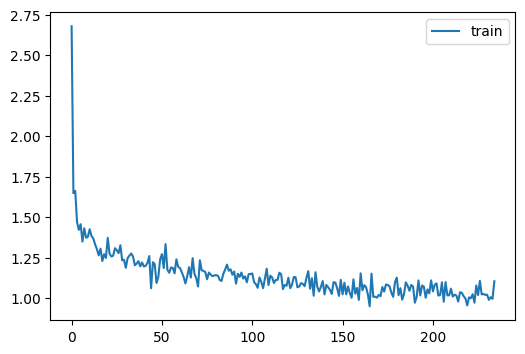

Fit 1 in: 25.24s, setup: 0.00s, 23.32 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(3093770124)


accuracy,loss,epoch,train
0.801,1.136,0,train
0.901,0.383,0,eval


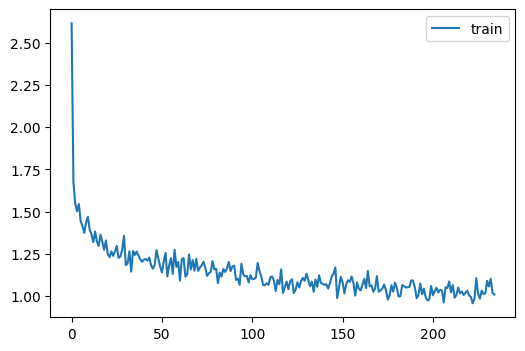

Fit 1 in: 25.63s, setup: 0.00s, 23.36 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4005303368)


accuracy,loss,epoch,train
0.801,1.138,0,train
0.899,0.386,0,eval


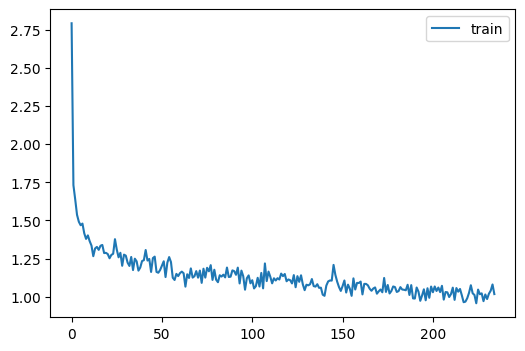

Fit 1 in: 25.36s, setup: 0.00s, 23.39 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(491263)


accuracy,loss,epoch,train
0.804,1.132,0,train
0.902,0.383,0,eval


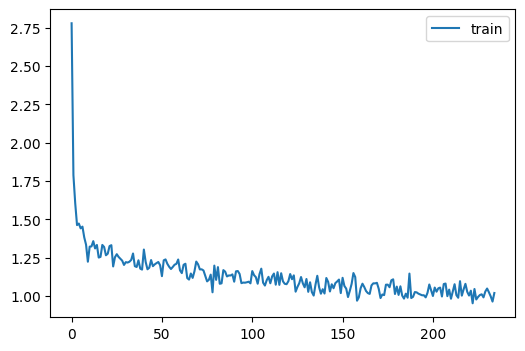

Fit 1 in: 25.45s, setup: 0.00s, 23.48 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(550290313)


accuracy,loss,epoch,train
0.802,1.138,0,train
0.900,0.387,0,eval


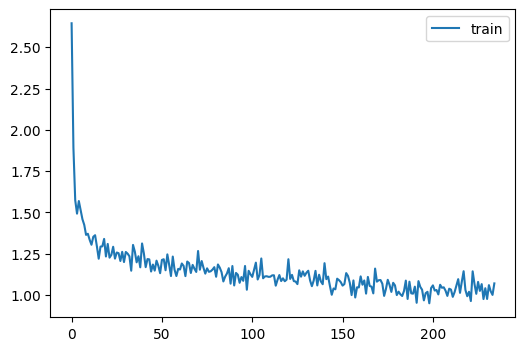

Fit 1 in: 25.66s, setup: 0.00s, 23.68 ± 0.00s per epoch, 0.02 ± 0.00s per batch
Batch size 256
Using seed tensor(1298508491)


accuracy,loss,epoch,train
0.800,1.137,0,train
0.906,0.380,0,eval


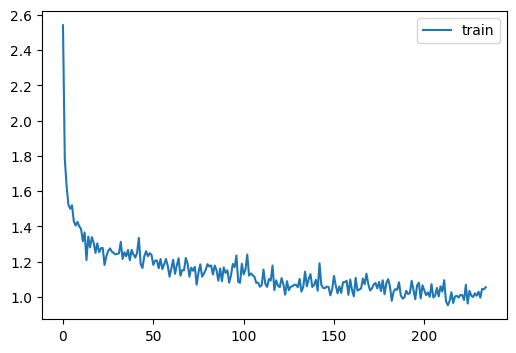

Fit 1 in: 25.48s, setup: 0.00s, 23.51 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4290846341)


accuracy,loss,epoch,train
0.809,1.127,0,train
0.906,0.377,0,eval


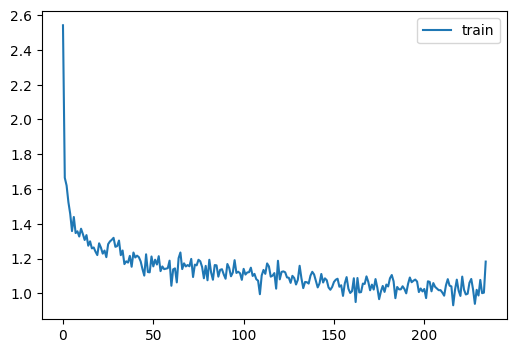

Fit 1 in: 25.46s, setup: 0.00s, 23.49 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(630311759)


accuracy,loss,epoch,train
0.806,1.133,0,train
0.906,0.377,0,eval


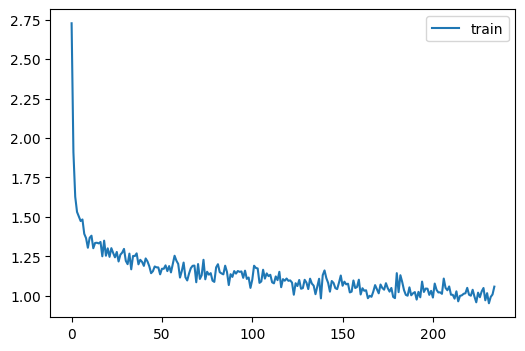

Fit 1 in: 25.43s, setup: 0.00s, 23.48 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(1013994432)


accuracy,loss,epoch,train
0.807,1.128,0,train
0.904,0.385,0,eval


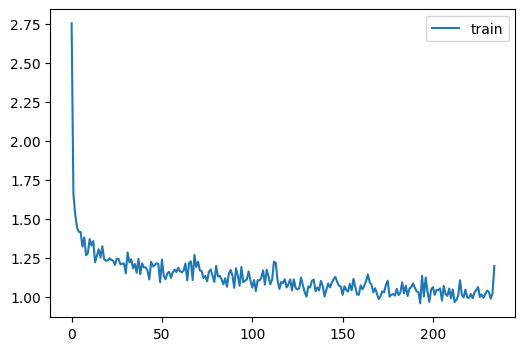

Fit 1 in: 25.45s, setup: 0.00s, 23.51 ± 0.00s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
results =[] 
for s in torch.randint(2**32 - 1,(10,)):
    rng.set_seed(s)
    learn1 = run(
        get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
        base_lr=1e-2, epochs=1, 
        cbs=[], 
        train_cb=MixUpCB(0.4, use_prev=False, eta=None, per_batch=False, loss_func=mce_int_prec, label_smoothing=0.1), fit=True)
    results.append(metrics.metrics['accuracy'].compute().item())
    

Batch size 256
Using seed tensor(1791095845)


accuracy,loss,epoch,train
0.439,1.122,0,train
0.905,0.387,0,eval


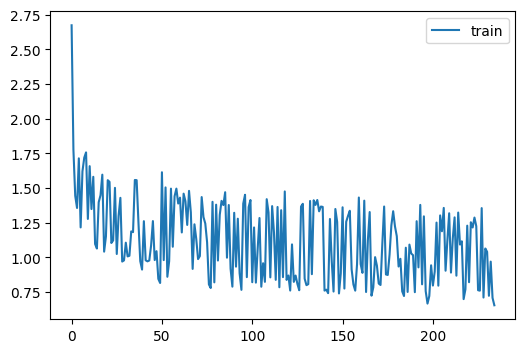

Fit 1 in: 25.40s, setup: 0.00s, 23.46 ± 0.00s per epoch, 0.04 ± 0.01s per batch
Batch size 256
Using seed tensor(4282876139)


accuracy,loss,epoch,train
0.468,1.128,0,train
0.904,0.410,0,eval


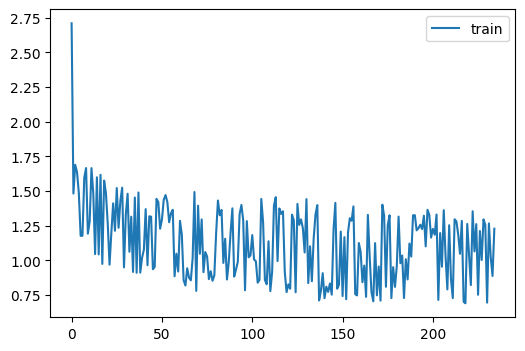

Fit 1 in: 25.38s, setup: 0.00s, 23.44 ± 0.00s per epoch, 0.04 ± 0.00s per batch
Batch size 256
Using seed tensor(3093770124)


accuracy,loss,epoch,train
0.492,1.123,0,train
0.905,0.395,0,eval


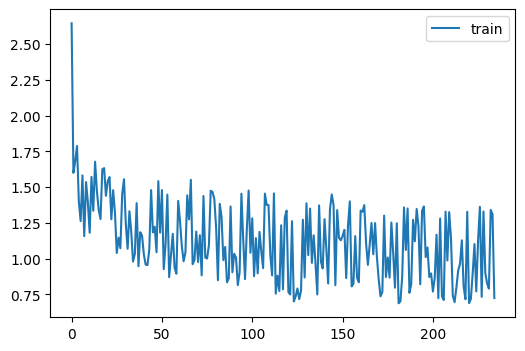

Fit 1 in: 25.46s, setup: 0.00s, 23.53 ± 0.00s per epoch, 0.04 ± 0.00s per batch
Batch size 256
Using seed tensor(4005303368)


accuracy,loss,epoch,train
0.508,1.094,0,train
0.905,0.394,0,eval


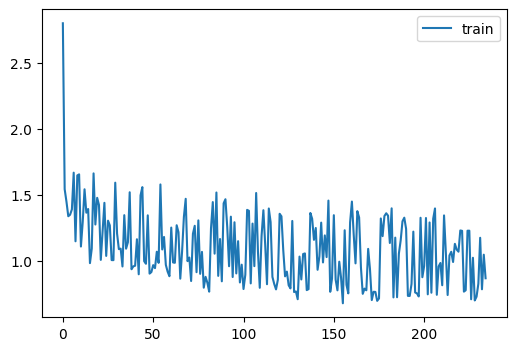

Fit 1 in: 25.48s, setup: 0.00s, 23.56 ± 0.00s per epoch, 0.04 ± 0.00s per batch
Batch size 256
Using seed tensor(491263)


accuracy,loss,epoch,train
0.471,1.129,0,train
0.907,0.409,0,eval


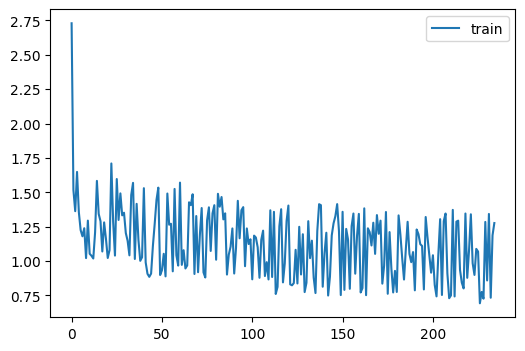

Fit 1 in: 25.61s, setup: 0.00s, 23.66 ± 0.00s per epoch, 0.04 ± 0.00s per batch
Batch size 256
Using seed tensor(550290313)


accuracy,loss,epoch,train
0.541,1.111,0,train
0.908,0.395,0,eval


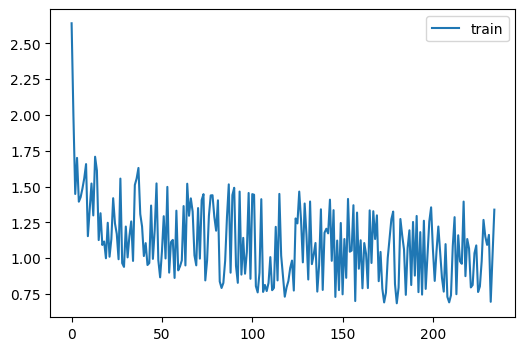

Fit 1 in: 25.58s, setup: 0.00s, 23.65 ± 0.00s per epoch, 0.04 ± 0.00s per batch
Batch size 256
Using seed tensor(1298508491)


accuracy,loss,epoch,train
0.467,1.114,0,train
0.909,0.391,0,eval


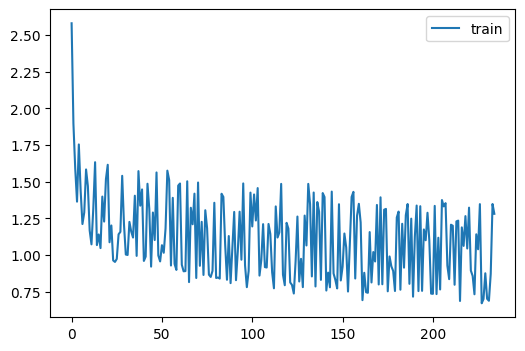

Fit 1 in: 25.57s, setup: 0.00s, 23.64 ± 0.00s per epoch, 0.04 ± 0.00s per batch
Batch size 256
Using seed tensor(4290846341)


accuracy,loss,epoch,train
0.505,1.104,0,train
0.908,0.386,0,eval


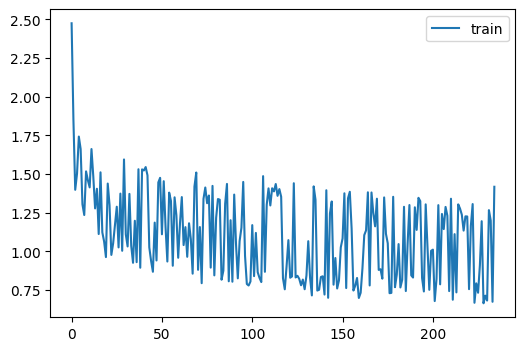

Fit 1 in: 25.52s, setup: 0.00s, 23.61 ± 0.00s per epoch, 0.04 ± 0.00s per batch
Batch size 256
Using seed tensor(630311759)


accuracy,loss,epoch,train
0.517,1.119,0,train
0.912,0.388,0,eval


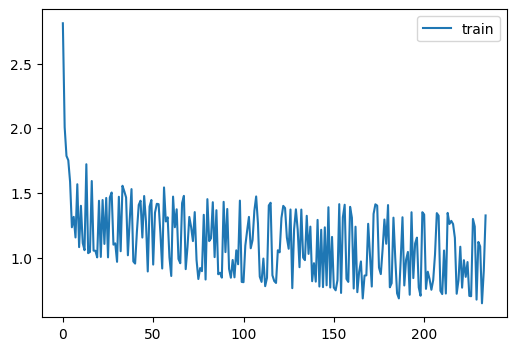

Fit 1 in: 25.49s, setup: 0.00s, 23.59 ± 0.00s per epoch, 0.04 ± 0.00s per batch
Batch size 256
Using seed tensor(1013994432)


accuracy,loss,epoch,train
0.509,1.131,0,train
0.909,0.389,0,eval


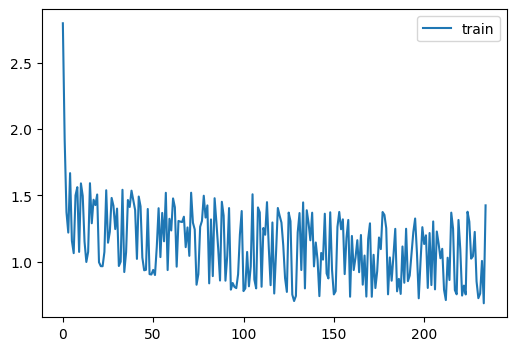

Fit 1 in: 25.50s, setup: 0.00s, 23.60 ± 0.00s per epoch, 0.04 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
results2 =[] 
for s in torch.randint(2**32 - 1,(10,)):
    rng.set_seed(s)
    learn1 = run(
        get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
        base_lr=1e-2, epochs=1, 
        cbs=[], 
        train_cb=MixUpCBOld(0.4, label_smoothing=0.1), fit=True)
    results2.append(metrics.metrics['accuracy'].compute().item())
    

Batch size 256
Using seed tensor(1791095845)


accuracy,loss,epoch,train
0.810,1.119,0,train
0.904,0.375,0,eval


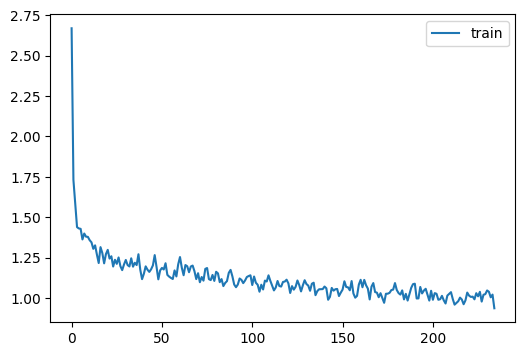

Fit 1 in: 24.82s, setup: 0.00s, 22.89 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4282876139)


accuracy,loss,epoch,train
0.810,1.122,0,train
0.904,0.379,0,eval


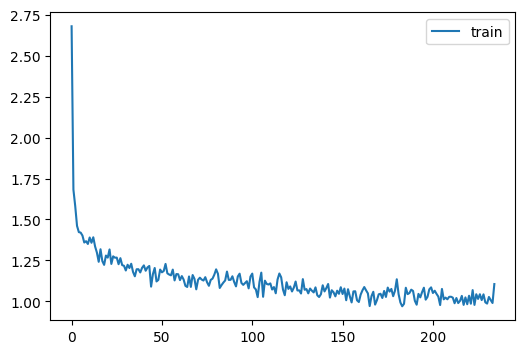

Fit 1 in: 24.90s, setup: 0.00s, 22.97 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(3093770124)


accuracy,loss,epoch,train
0.808,1.123,0,train
0.900,0.381,0,eval


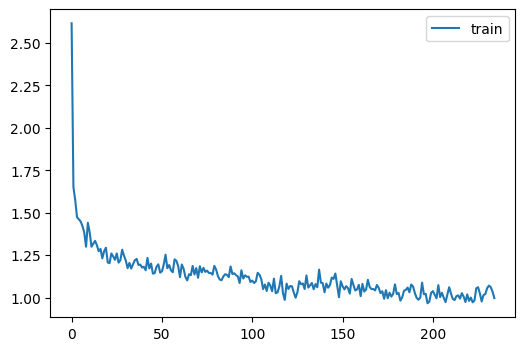

Fit 1 in: 25.05s, setup: 0.00s, 23.15 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4005303368)


accuracy,loss,epoch,train
0.808,1.127,0,train
0.904,0.380,0,eval


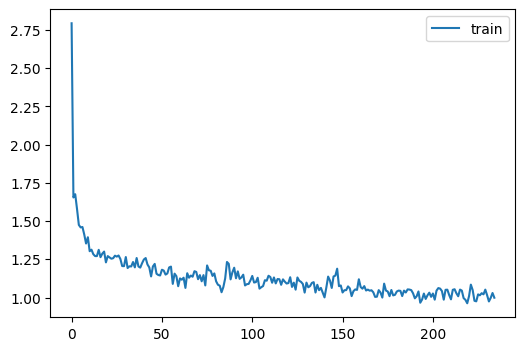

Fit 1 in: 25.15s, setup: 0.00s, 23.22 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(491263)


accuracy,loss,epoch,train
0.810,1.117,0,train
0.905,0.375,0,eval


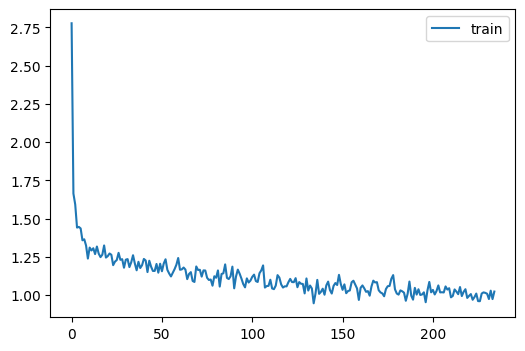

Fit 1 in: 25.19s, setup: 0.00s, 23.27 ± 0.00s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
results6 =[] 
for s in torch.randint(2**32 - 1,(5,)):
    rng.set_seed(s)
    learn1 = run(
        get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
        base_lr=1e-2, epochs=1, 
        cbs=[], 
        train_cb=MixUpCB(0.4, use_prev=True, eta=None, per_batch=False, loss_func=mce_int, label_smoothing=0.1), fit=True)
    results6.append(metrics.metrics['accuracy'].compute().item())
    

Batch size 256
Using seed tensor(1791095845)


accuracy,loss,epoch,train
0.486,0.843,0,train
0.903,0.316,0,eval


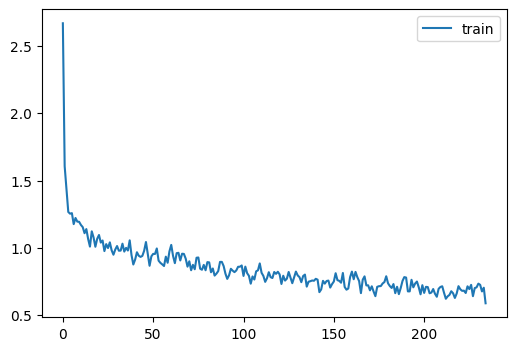

Fit 1 in: 25.22s, setup: 0.00s, 23.32 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4282876139)


accuracy,loss,epoch,train
0.483,0.847,0,train
0.905,0.319,0,eval


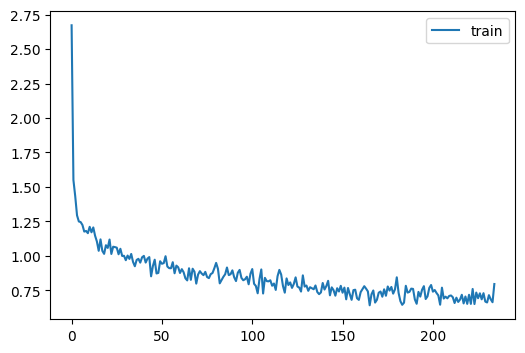

Fit 1 in: 25.26s, setup: 0.00s, 23.34 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(3093770124)


accuracy,loss,epoch,train
0.483,0.847,0,train
0.899,0.323,0,eval


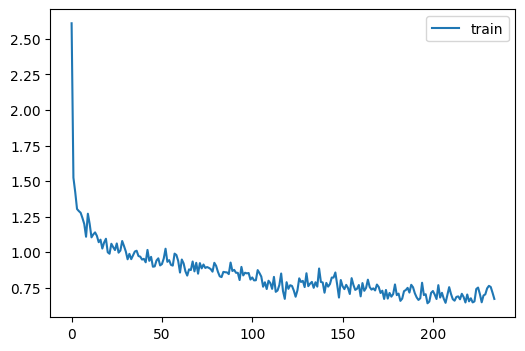

Fit 1 in: 25.29s, setup: 0.00s, 23.37 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(4005303368)


accuracy,loss,epoch,train
0.487,0.852,0,train
0.902,0.321,0,eval


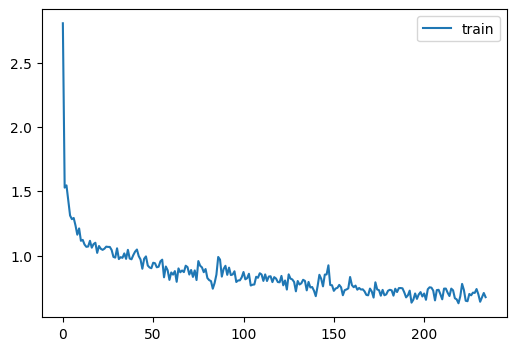

Fit 1 in: 25.26s, setup: 0.00s, 23.36 ± 0.00s per epoch, 0.01 ± 0.00s per batch
Batch size 256
Using seed tensor(491263)


accuracy,loss,epoch,train
0.483,0.840,0,train
0.905,0.314,0,eval


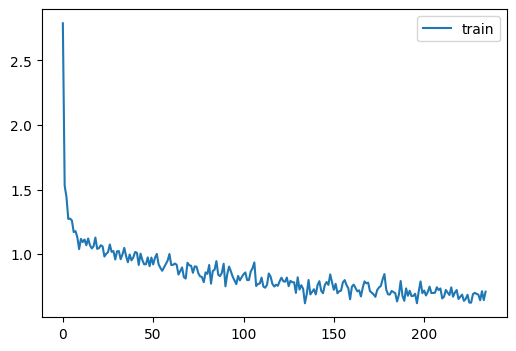

Fit 1 in: 25.26s, setup: 0.00s, 23.35 ± 0.00s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.set_seed(1)
results7 =[] 
for s in torch.randint(2**32 - 1,(5,)):
    rng.set_seed(s)
    learn1 = run(
        get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
        base_lr=1e-2, epochs=1, 
        cbs=[], 
        train_cb=MixUpCB(0.4, use_prev=True, eta=None, per_batch=False, loss_func=mce_int, label_smoothing=0.0), fit=True)
    results7.append(metrics.metrics['accuracy'].compute().item())

In [ ]:
import pandas as pd
pd.DataFrame([results,      results2[:10],           results3[:10],     results4,          results5,          results6,   results7], 
index=['N per sample, 0.1','O per batch, 0.1', 'N per batch, 0.0','O per batch, 0.0', 'no mixup, 0.0', 'N prev,sample, 0.1', 'N prev,sample, 0.0'])

,0,1,2,3,4,5,6,7,8,9
"N per sample, 0.1",0.9026,0.9042,0.9027,0.9001,0.9020,0.9014,0.9057,0.9058,0.9049,0.9054
"O per batch, 0.1",0.9048,0.9040,0.9055,0.9047,0.9066,0.9082,0.9085,0.9081,0.9118,0.9090
"N per batch, 0.0",0.9037,0.9032,0.9048,0.9047,0.9077,0.9063,0.9069,0.9082,0.9090,0.9094
"O per batch, 0.0",0.9037,0.9032,0.9048,0.9047,0.9077,0.9063,0.9069,0.9082,0.9090,0.9094
"no mixup, 0.0",0.9127,0.9093,0.9119,0.9100,0.9107,0.9115,0.9117,0.9119,0.9131,0.9142
"N prev,sample, 0.1",0.9029,0.9048,0.8992,0.9020,0.9048,NaN,NaN,NaN,NaN,NaN
"N prev,sample, 0.0",0.9029,0.9048,0.8992,0.9020,0.9048,NaN,NaN,NaN,NaN,NaN


### CMP 20 epochs

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.490,1.126,0,train
0.880,0.513,0,eval
0.510,1.057,1,train
0.901,0.400,1,eval
0.529,1.011,2,train
0.915,0.374,2,eval
0.512,0.998,3,train
0.918,0.342,3,eval
0.477,0.969,4,train
0.923,0.380,4,eval


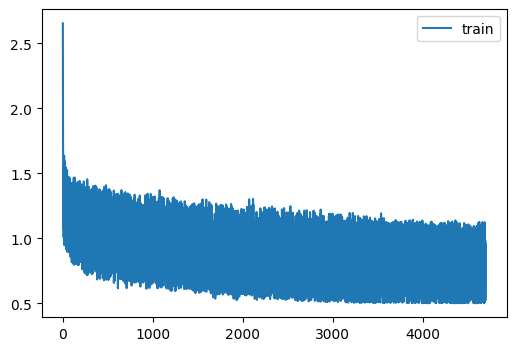

Fit 20 in: 509.82s, setup: 0.00s, 23.58 ± 0.08s per epoch, 0.04 ± 0.00s per batch
-0.056461360305547714
tensor([-1.71781194, -0.51013136, -0.28861845,  0.72152680,  0.83603626, -1.98357928,  1.23935509, -0.66814113, -0.66870362,  0.49368286])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=20, 
    cbs=[], 
    train_cb=MixUpCBOld(0.4, label_smoothing=0.1), fit=True)
print(learn1.model(xb.to('cuda')).mean().item()),
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.485,0.897,0,train
0.891,0.490,0,eval
0.501,0.785,1,train
0.902,0.360,1,eval
0.497,0.695,2,train
0.907,0.320,2,eval
0.520,0.661,3,train
0.920,0.279,3,eval
0.564,0.611,4,train
0.912,0.305,4,eval


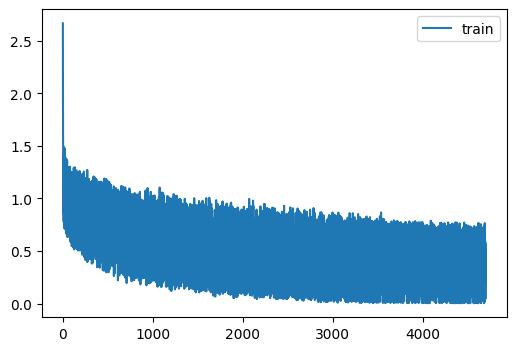

Fit 20 in: 506.35s, setup: 0.00s, 23.40 ± 0.05s per epoch, 0.01 ± 0.00s per batch
0.20578189194202423
tensor([-1.71781194, -0.51013136, -0.28861845,  0.72152680,  0.83603626, -1.98357928,  1.23935509, -0.66814113, -0.66870362,  0.49368286])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=20, 
    cbs=[], 
    train_cb=MixUpCB(0.4, use_prev=False, eta=None, per_batch=True, label_smoothing=0.1), fit=True)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.483,0.924,0,train
0.883,0.456,0,eval
0.504,0.771,1,train
0.894,0.378,1,eval
0.503,0.702,2,train
0.903,0.315,2,eval
0.514,0.644,3,train
0.910,0.287,3,eval
0.518,0.609,4,train
0.919,0.256,4,eval


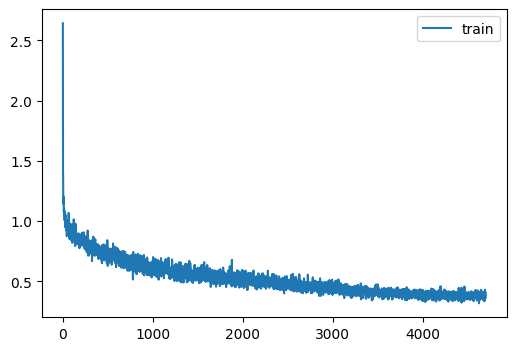

Fit 20 in: 506.47s, setup: 0.00s, 23.40 ± 0.02s per epoch, 0.01 ± 0.00s per batch
lam tensor([    0.52552468,     0.02442432,     0.17364037,     0.67338437,     0.18108995,     0.99775034,     0.96209472,     0.92988640,
            0.17557794,     0.41593814,     0.04615306,     0.06022141,     0.93450367,     0.39759177,     0.00000747,     0.26552776,
            0.72831488,     0.01831994,     0.91011590,     0.08316126,     0.86101234,     0.99996334,     0.35128859,     0.99182445,
            0.17228632,     0.33321953,     0.18648113,     0.98342741,     0.00058535,     0.88880467,     0.99785507,     0.63015711,
            0.91072559,     0.95543140,     0.95421767,     0.01017770,     0.37351432,     0.65680587,     0.97772688,     0.20902403,
            0.65236086,     0.28446636,     0.00041902,     0.39774770,     0.98739880,     0.80271006,     0.99829924,     0.06359376,
            0.98535454,     0.85125655,     0.00078182,     0.13301371,     0.99955899,     0.8078

In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=20, 
    cbs=[], 
    train_cb=MixUpCB(0.4, use_prev=True, eta=None, per_batch=False,  label_smoothing=0.1), fit=True)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

# Dynamic mixup loss function

## Authors impl


In [55]:
#| export
#https://github.com/Westlake-AI/openmixup/blob/c042813ee0af577d365f0e13b13a4c8486d6e8f7/openmixup/models/losses/cross_entropy_loss.py#L83

def _weight_reduce_loss(loss, weight=None, reduction='mean', avg_factor=None):
    """Apply element-wise weight and reduce loss.
    Args:
        loss (Tensor): Element-wise loss tensor.
        weight (Tensor): Element-wise weights.
        reduction (str): Same as built-in losses of PyTorch. Options are "none",
            "mean" and "sum".
        avg_factor (float): Avarage factor when computing the mean of losses.
    Returns:
        Tensor: Processed loss values.
    """
    # if weight is specified, apply element-wise weight
    if weight is not None:
        loss = loss * weight

    reduction_enum = F._Reduction.get_enum(reduction)
    # if avg_factor is not specified, just reduce the loss
    if avg_factor is None:
        # none: 0, elementwise_mean:1, sum: 2
        if reduction_enum == 1:
            loss = loss.mean()
        elif reduction_enum == 2:
            loss = loss.sum()
    else:
        # if reduction is 'mean', then average the loss by avg_factor
        if reduction_enum == 1:
            loss = loss.sum() / avg_factor
        # if reduction is 'none', then do nothing; otherwise raise an error
        elif reduction != 0:
            raise ValueError('avg_factor can not be used with reduction="sum"')
    return loss

def _soft_mix_cross_entropy(pred,
                           label,
                           weight=None,
                           reduction='mean',
                           class_weight=None,
                           avg_factor=None,
                           eta_weight=None,
                           eps_smooth=1e-3,
                           verbose=False,
                           weight_reduce_loss=_weight_reduce_loss,
                           **kwargs):
    r"""Calculate the Soft Decoupled Mixup CrossEntropy loss using softmax
        The label can be float mixup label (class-wise sum to 1, k-mixup, k>=2).
       *** Warnning: this mixup and label-smoothing cannot be set simultaneously ***
    Decoupled Mixup for Data-efficient Learning. In arXiv, 2022.
    <https://arxiv.org/abs/2203.10761>
    Args:
        pred (torch.Tensor): The prediction with shape (N, C), C is the number
            of classes.
        label (torch.Tensor): The gt label of the prediction with shape (N, C).
            When using "mixup", the label can be float (mixup one-hot label).
        weight (torch.Tensor, optional): Sample-wise loss weight.
        reduction (str): The method used to reduce the loss.
        avg_factor (int, optional): Average factor that is used to average
            the loss. Defaults to None.
        class_weight (torch.Tensor, optional): The weight for each class with
            shape (C), C is the number of classes. Default None.
        eta_weight (list): Reweight the global loss in mixup cls loss as,
            loss = loss_local + eta_weight[i] * loss_global[i]. Default to None.
        eps_smooth (float): If using label smoothing, we assume eps < lam < 1-eps.
    Returns:
        torch.Tensor: The calculated loss
    """
    # *** Assume k-mixup in C classes, k >= 2 and k << C ***
    # step 1: remove labels have less than k-hot (mixed between the
    #    same class will result in the original onehot)
    _eps = max(1e-3, eps_smooth)  # assuming _eps < lam < 1-_eps
    mask_one = (label > _eps).sum(dim=-1)
    mix_num = max(mask_one)
    mask_one = mask_one >= mix_num
    if mask_one.sum() < label.size(0):
        pred_one = pred[mask_one==False, :]
        label_one = label[mask_one==False, :]
        pred = pred[mask_one, :]
        label = label[mask_one, :]
        weight_one = None
        if weight is not None:
            weight_one = weight[mask_one==False, ...].float()
            weight = weight[mask_one, ...].float()
        if verbose: print(f"pred_one: {mask_one=} {pred_one=}")
    else:
        if weight is not None:
            weight = weight.float()
        pred_one, label_one, weight_one = None, None, None
        if verbose: print(f"no pred_one {mask_one=}")
    # step 2: select k-mixup for the local and global
    bs, cls_num = label.size()  # N, C
    assert isinstance(eta_weight, list)
    # local: between k classes
    mask_lam_k = label > _eps  # [N, N], top k is true
    lam_k = label[0, label[0, :] > _eps]  # [k,] k-mix relevant classes

    # local: original mixup CE loss between C classes
    loss = -label * F.log_softmax(pred, dim=-1)  # [N, N]
    if class_weight is not None:
        loss *= class_weight
    loss = loss.sum(dim=-1)  # reduce class

    # global: between lam_i and C-k classes
    if len(set(lam_k.cpu().numpy())) == lam_k.size(0) and lam_k.size(0) > 1:
        if verbose: print("calculating global loss for", lam_k, 'loss so far', loss)
        # *** trivial solution: lam=0.5, lam=1.0 ***
        assert len(eta_weight) == lam_k.size(0), \
            "eta weight={}, lam_k={}".format(eta_weight, lam_k)
        for i in range(lam_k.size(0)):
            # selected (C-k+1), except lam_k[j], where j!=i (k-1)
            mask_lam_i = (label == lam_k[i]) | ~mask_lam_k  # [N, N]
            pred_lam_i  = pred.reshape([1, bs, -1])[:, mask_lam_i].reshape(
                [-1, cls_num+1-lam_k.size(0)])  # [N, C-k+1]
            label_lam_i = label.reshape([1, bs, -1])[:, mask_lam_i].reshape(
                [-1, cls_num+1-lam_k.size(0)])  # [N, C-k+1]
            # convert to onehot
            label_lam_i = (label_lam_i > 0).type(torch.float)
            # element-wise losses
            loss_global = -label_lam_i * F.log_softmax(pred_lam_i, dim=-1)  # [N, C-1]
            if class_weight is not None:
                loss_global *= class_weight
            # eta reweight
            if verbose: print(f"global loss: {loss_global.sum(dim=-1)} for {lam_k[i]}")
            loss += eta_weight[i] * loss_global.sum(dim=-1)  # reduce class
    # apply weight and do the reduction
    loss = weight_reduce_loss(
        loss, weight=weight, reduction=reduction, avg_factor=avg_factor)

    # step 3: original soft CE loss
    if label_one is not None:
        loss_one = -label_one * F.log_softmax(pred_one, dim=-1)
        if class_weight is not None:
            loss_one *= class_weight
        loss_one = loss_one.sum(dim=-1)  # reduce class
        if verbose: print(f"loss_one: {loss_one=} {loss=}")

        loss_one = weight_reduce_loss(
            loss_one, weight=weight_one, reduction=reduction, avg_factor=avg_factor)
        loss += loss_one or 0.0

    return loss


## Our impl

In [93]:
set_seed(1)
b = 20
a = 10.
x1 = tensor([[1,  1, a, 1],
             [a,  1, 1, 1]]).float()
x2 = tensor([[1,  b, 1, 1],
             [1,  1, 1, b]]).float()
y1 = (x1).argmax(-1)
y2 = (x2).argmax(-1) 

print(y1, y2)
r = mixup_data_int((x1,y1), (x2,y2), classes=4, permute_1=False,)


tensor([2, 0]) tensor([1, 3])


In [94]:
r

namespace(lam=tensor([0.73126239, 0.79491055]),
          mixed_x=tensor([[ 1.00000000, 14.89398575,  3.41863847,  1.00000000],
                          [ 2.84580517,  1.00000000,  1.00000000, 16.10330009]]),
          y1=tensor([1, 3]),
          y2=tensor([2, 0]),
          y=tensor([[2, 1],
                    [0, 3]]),
          top1y=tensor([1, 3]))

In [78]:
y1.sum??

Docstring:
sum(dim=None, keepdim=False, dtype=None) -> Tensor

See :func:`torch.sum`
Type:      builtin_function_or_method

In [95]:
#|export
def mixup_bce(preds, r, eta=None, verbose=False, label_smoothing=0.1, **kw): 
    K = preds.shape[-1]
    y1 = F.one_hot(r.y1, K).float()
    y2 = F.one_hot(r.y2, K).float()
    mixed_y = torch.lerp(y2, y1, r.lam.reshape(-1,*[1]*(len(y2.shape)-1)))
    if label_smoothing:
        mixed_y = mixed_y * (1-label_smoothing) + label_smoothing
    if verbose: 
        print(y1)
        print(y2)
        print(r.lam)
        print(f"{mixed_y}")
    return F.binary_cross_entropy_with_logits(preds, mixed_y, **kw)

In [99]:
mixup_bce(r.mixed_x, r, verbose=True, label_smoothing=0.1)

tensor([[0., 1., 0., 0.],
        [0., 0., 0., 1.]])
tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.]])
tensor([0.73126239, 0.79491055])
tensor([[0.10000000, 0.75813615, 0.34186384, 0.10000000],
        [0.28458050, 0.10000000, 0.10000000, 0.81541950]])


tensor(1.97528601)

In [88]:
F.binary_cross_entropy_with_logits??

Signature:
F.binary_cross_entropy_with_logits(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    size_average: Optional[bool] = None,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
    pos_weight: Optional[torch.Tensor] = None,
) -> torch.Tensor
Source:   
def binary_cross_entropy_with_logits(
    input: Tensor,
    target: Tensor,
    weight: Optional[Tensor] = None,
    size_average: Optional[bool] = None,
    reduce: Optional[bool] = None,
    reduction: str = "mean",
    pos_weight: Optional[Tensor] = None,
) -> Tensor:
    r"""Function that measures Binary Cross Entropy between target and input
    logits.

    See :class:`~torch.nn.BCEWithLogitsLoss` for details.

    Args:
        input: Tensor of arbitrary shape as unnormalized scores (often referred to as logits).
        target: Tensor of the same shape as input with values between 0 and 1
        weight (Tensor, optional): a manual rescaling weight
            

In [20]:
(0.73 * b+ 0.27 * 1), 0.2689*a+ 0.73*1

(14.87, 3.4189999999999996)

In [23]:
# lets construct the mask manually
maskb = r.mixed_x>14
maska = (r.mixed_x>2) & (~maskb)
r.mixed_x[maska]

tensor([3.41863847, 2.84580517])

In [24]:
r.mixed_x[maskb]

tensor([14.89398575, 16.10330009])

In [25]:
pred=r.mixed_x[~maskb].reshape(2, -1) 
lbl=maska[~maskb].reshape(2, -1).float()
print(pred,lbl)
F.cross_entropy(pred, lbl, reduction='mean').item()

tensor([[1.00000000, 3.41863847, 1.00000000],
        [2.84580517, 1.00000000, 1.00000000]]) tensor([[0., 1., 0.],
        [1., 0., 0.]])


0.21916639804840088

In [34]:
F.softmax(pred)

/tmp/ipykernel_25743/2623642980.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(pred)


tensor([[0.07558259, 0.84883475, 0.07558259],
        [0.75999600, 0.12000194, 0.12000194]])

In [37]:
lbl

tensor([[0., 1., 0.],
        [1., 0., 0.]])

In [47]:
F.log_softmax(pred)[lbl==1]

/tmp/ipykernel_25743/2962412577.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  F.log_softmax(pred)[lbl==1]


tensor([-0.16389072, -0.27444208])

In [44]:
#|export
def ce_masked(preds, y, ignored_y, **kwargs):
    """
    y - one hot encoded label
    ingored_y - one hot encloded of ignored class
    """
    N, C = preds.shape
    mask = ignored_y==0
    mpreds = preds[mask].reshape(N, C-1)
    my = y[mask].float().reshape(N, C-1)
    return F.cross_entropy(mpreds, my, reduction='none', **kwargs)

In [46]:

y1 = F.one_hot(r.y1, 4)
y2 = F.one_hot(r.y2, 4)
ce_masked(r.mixed_x, y2, y1)

tensor([0.16389072, 0.27444208])

In [28]:
ce_masked(r.mixed_x, y1, y1).item() + ce_masked(r.mixed_x, y2, y2).item() 

-0.0

In [65]:
mce_int??

Signature: mce_int(preds, r, eta=None, **kw)
Docstring: <no docstring>
Source:   
def mce_int(preds, r, eta=None, **kw):
    ce = torch.lerp(F.cross_entropy(preds, r.y2, reduction='none', **kw), 
                    F.cross_entropy(preds, r.y1, reduction='none', **kw), r.lam)
    return ce.mean(-1)
File:      /tmp/ipykernel_25743/2661331135.py
Type:      function

In [68]:
#| export
def dmce(preds, r, eta=0.1, verbose=False, **kw): 
    mce = mce_int(preds, r, reduction=False, **kw)
    y1 = F.one_hot(r.y1, preds.shape[-1])
    y2 = F.one_hot(r.y2, preds.shape[-1])
    dmce1 = ce_masked(preds, y1, y2, **kw)
    dmce2 = ce_masked(preds, y2, y1, **kw)
    if verbose: print(f"{mce} + {eta}*{dmce1} + {eta}*{dmce2}")
    return (mce + eta*dmce1 + eta*dmce2).mean()

def dmce_orig(preds, r, eta=[0.1,0.1], verbose=False, **kw):
    y1 = F.one_hot(r.y1, preds.shape[-1]).float()
    y2 = F.one_hot(r.y2, preds.shape[-1]).float()
    mixed_y = torch.lerp(y2,y1,r.lam[...,None])
    return _soft_mix_cross_entropy(preds, mixed_y, eta_weight=eta, verbose=verbose)                

In [ ]:
dmce_c=dmce_orig

In [69]:
set_seed(1)
b = 20
a = 11.
x1 = tensor([[1,  1, a, 1],
             [a,  1, 1, 1]]).float()
x2 = tensor([[1,  b, 1, 1],
             [1,  1, 1, b]]).float()
y1 = (x1).argmax(-1)
y2 = (x2).argmax(-1) 

print(y1, y2)
r = mixup_data_int((x1,y1), (x2,y2), classes=4, permute_1=False, sampler=lambda x: torch.tensor([0.3, 1.0]))
v = dmce_orig(r.mixed_x, r, verbose=True)
print("")
print("origin: ", v)
print("")
v = dmce(r.mixed_x, r, eta=0.2, verbose=True)
print("our:   ", v)

tensor([2, 0]) tensor([1, 3])
pred_one: mask_one=tensor([ True, False]) pred_one=tensor([[ 1.,  1.,  1., 20.]])
calculating global loss for tensor([0.30000001, 0.69999999]) loss so far tensor([0.63244051])
global loss: tensor([0.00666964]) for 0.30000001192092896
global loss: tensor([0.00182200]) for 0.699999988079071
loss_one: loss_one=tensor([0.]) loss=tensor(0.63328969)

origin:  tensor(0.63328969)

tensor([0.63244051, 0.00000000]) + 0.2*tensor([0.00666964, -0.00000000]) + 0.2*tensor([0.00182200, 1.09861231])
our:    tensor(0.42693067)


## Tests

In [ ]:
mce = mce_int

### [94.0] nomixup

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.866,0.517,0,train
0.882,0.356,0,eval
0.907,0.277,1,train
0.903,0.289,1,eval
0.928,0.207,2,train
0.922,0.209,2,eval
0.949,0.146,3,train
0.936,0.186,3,eval
0.972,0.084,4,train
0.940,0.182,4,eval


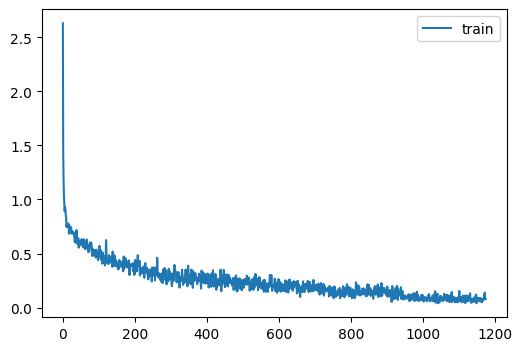

Fit 5 in: 125.62s, setup: 0.00s, 23.22 ± 0.07s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[])

### [93.9] MCE, single_lam

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.481,0.871,0,train
0.868,0.397,0,eval
0.504,0.707,1,train
0.872,0.365,1,eval
0.495,0.630,2,train
0.913,0.309,2,eval
0.529,0.584,3,train
0.935,0.208,3,eval
0.574,0.525,4,train
0.939,0.215,4,eval


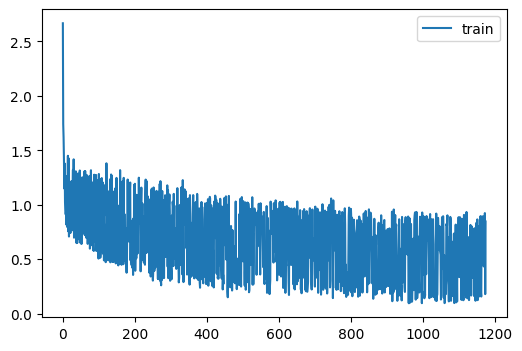

Fit 5 in: 126.38s, setup: 0.00s, 23.38 ± 0.01s per epoch, 0.01 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.4, use_prev=True, eta=None, per_batch=True, loss_func=mce, label_smoothing=0.0))

### [92.0] DMCE copy, per_batch eta 0.1, 0.1

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.493,1.823,0,train
0.851,0.444,0,eval
0.497,1.389,1,train
0.894,0.314,1,eval
0.513,1.151,2,train
0.900,0.300,2,eval
0.520,1.070,3,train
0.914,0.248,3,eval
0.509,0.926,4,train
0.920,0.234,4,eval


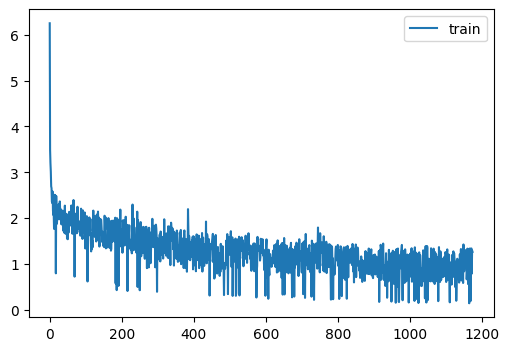

Fit 5 in: 144.63s, setup: 0.00s, 27.03 ± 0.11s per epoch, 0.05 ± 0.01s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=[0.1,0.1], per_batch=True, loss_func=dmce_c, label_smoothing=0.0))

### [93.2] DMCE (our), per_batch

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.508,1.756,0,train
0.837,0.539,0,eval
0.512,1.342,1,train
0.900,0.342,1,eval
0.521,1.151,2,train
0.915,0.266,2,eval
0.530,1.039,3,train
0.930,0.233,3,eval
0.518,0.923,4,train
0.932,0.228,4,eval


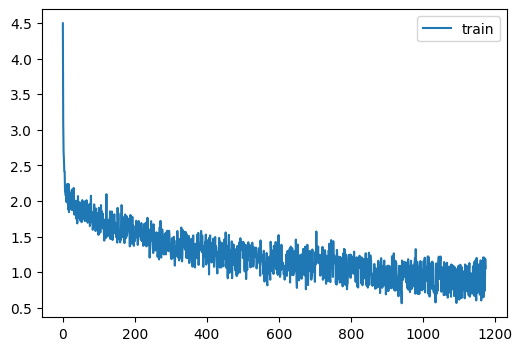

Fit 5 in: 128.12s, setup: 0.00s, 23.63 ± 0.02s per epoch, 0.04 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=True, loss_func=dmce, label_smoothing=0.0))

### [92.5] DMCE copy, per_batch eta[0.1,0.9]

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.498,2.732,0,train
0.741,0.745,0,eval
0.506,2.020,1,train
0.887,0.357,1,eval
0.517,1.661,2,train
0.893,0.332,2,eval
0.524,1.466,3,train
0.919,0.284,3,eval
0.516,1.256,4,train
0.925,0.224,4,eval


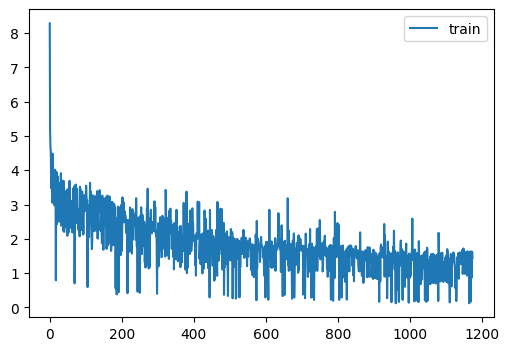

Fit 5 in: 146.02s, setup: 0.00s, 27.29 ± 0.04s per epoch, 0.06 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=[0.1,0.9], per_batch=True, loss_func=dmce_c, label_smoothing=0.0))

### [93.8] DCME (our), per_sample

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.487,1.759,0,train
0.875,0.415,0,eval
0.506,1.329,1,train
0.896,0.319,1,eval
0.514,1.144,2,train
0.907,0.329,2,eval
0.523,1.021,3,train
0.920,0.269,3,eval
0.529,0.909,4,train
0.938,0.211,4,eval


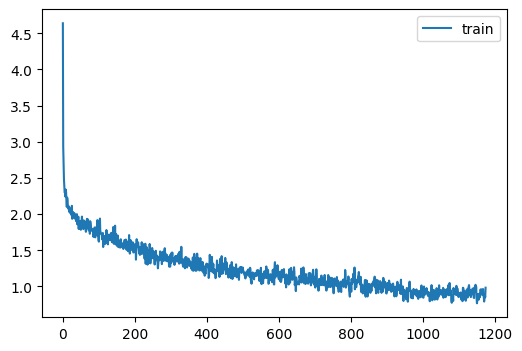

Fit 5 in: 127.96s, setup: 0.00s, 23.68 ± 0.03s per epoch, 0.04 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.0))


### [93.7] DCME (our), per_sample, lbl_smoothing

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.487,2.163,0,train
0.877,0.477,0,eval
0.509,1.889,1,train
0.895,0.417,1,eval
0.516,1.765,2,train
0.917,0.413,2,eval
0.523,1.677,3,train
0.924,0.325,3,eval
0.530,1.594,4,train
0.937,0.285,4,eval


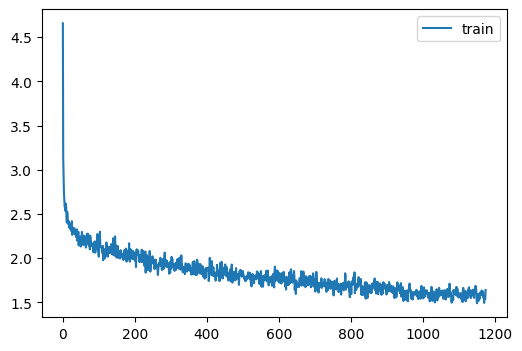

Fit 5 in: 128.68s, setup: 0.00s, 23.83 ± 0.01s per epoch, 0.04 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1))

Batch size 256
Using seed 1


accuracy,loss,epoch,train
0.797,2.146,0,train
0.872,0.462,0,eval
0.828,1.897,1,train
0.886,0.461,1,eval
0.848,1.769,2,train
0.861,0.522,2,eval
0.869,1.671,3,train
0.928,0.317,3,eval
0.891,1.584,4,train
0.938,0.280,4,eval


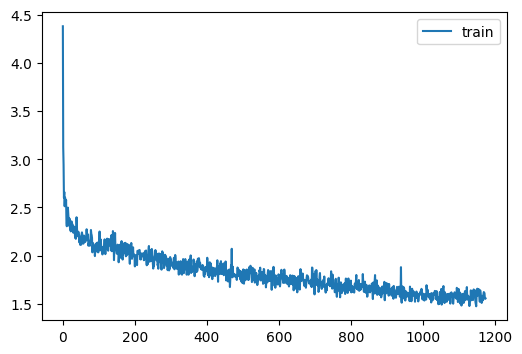

Fit 5 in: 257.45s, setup: 0.00s, 48.75 ± 0.35s per epoch, 0.09 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.3, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1))

## Test time augmentation

## Tests 20ep

In [ ]:
rng.previous()
# tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
# augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear')], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)
learn.model.save("resnet18d_ep20_0.1_mixup")

In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=20, 
    cbs=[augcb], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=20, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.2, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

In [ ]:
## 50ep

In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=50,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.2, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=50,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

In [ ]:
clean_tb()
clean_ipython_hist()
clean_mem()

In [ ]:
learn.model.save("resnet18d_ep50_0.1_mixup_dmce")

## Export

In [70]:
import nbdev; nbdev.nbdev_export()